In [1]:
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.gridspec as gridspec
import cmasher as cmr
cmap=cmr.sunburst_r
%matplotlib inline

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, SVI, Predictive, Trace_ELBO
from numpyro.infer.autoguide import AutoDelta, AutoNormal, AutoDiagonalNormal

from stream_membership import ComponentMixtureModel, ModelComponent
from stream_membership.distributions import IndependentGMM, TruncatedNormalSpline, DirichletSpline, TruncatedNormal1DSplineMixture
from stream_membership.plot import plot_data_projections

import astropy.table as at
import astropy.units as u

import pickle
from scipy.interpolate import InterpolatedUnivariateSpline as IUS

In [2]:
import importlib
import sys
sys.path.append('../../')

import scripts.initialize_stream as init_stream
from scripts.run_full_gd1_model import *

from cats.pawprint.pawprint import Pawprint, Footprint2D
from cats.CMD import Isochrone
from cats.inputs import stream_inputs as inputs
from cats.proper_motions import ProperMotionSelection, rough_pm_poly

In [4]:
data = at.Table.read("/Users/Tavangar/Work/gd1-dr3/data/GD1-region-alldata.fits")

pawprint,iso_obj,iso_mask,hb_mask,pmsel,pm_mask = run_CATS(data, stream_name='GD-1', phi1_lim=[-100,20])

Modifying/extrapolating galstreams track
Modifying/extrapolating galstreams track
-40.18182129005669
Fitting for peak pm location
Pre-fitting mean PM values: -13.031, -3.108
Post-fitting (pm1_mean, pm2_mean, pm1_std, pm2_std): [np.float64(-13.26720538330726), np.float64(-3.1634227867925135), np.float64(0.5151487185597746), np.float64(0.38624247171130377)] 

Producing the polygon and mask


/Users/Tavangar/Work/stream-membership/stream-env/lib/python3.12/site-packages/cats/CMD.py:293: RuntimeWarning: invalid value encountered in divide
  signal = signal / signal_counts


In [431]:
# columns = ['source_id','phi1','phi2','pm_phi1_cosphi2','pm_phi1_cosphi2_unrefl','pm_phi2','pm_phi2_unrefl','g0','r0','i0','pm1','pm2','pm1_error','pm2_error','rv','rv_err']

# run_sel = pm_mask & (iso_mask | hb_mask)
# run_data_ = iso_obj.cat[run_sel][columns]
# stream_sel0 = pmsel.pm12_mask & (iso_mask | hb_mask) & iso_obj.on_skymask
# stream_data0 = iso_obj.cat[stream_sel0][columns]
# def f(x,a,b):
#     return a*x+b
# popt,_ = curve_fit(f, np.array(stream_data0['phi1'][~np.isnan(stream_data0['rv']).mask]), np.array(stream_data0['rv'][~np.isnan(stream_data0['rv']).mask]))
# stream_sel = stream_sel0 & ((np.isnan(iso_obj.cat['rv'])) | (np.abs(iso_obj.cat['rv'] - f(iso_obj.cat['phi1'], *popt)) < 50))
# stream_data_ = iso_obj.cat[stream_sel][columns]

# bkg_data_ = iso_obj.cat[run_sel & ~stream_sel][columns]

# post_cats = {'run_data': run_data_,
#          'bkg_data': bkg_data_,
#          'stream_data': stream_data_,
#          'pawprint': pawprint,
#          'iso_obj': iso_obj}
# with open('../../data/for_adrian_post_cats_data.pkl', 'wb') as param_file:
#     pickle.dump(post_cats, param_file)

<TableColumns names=('source_id','phi1','phi2','pm_phi1_cosphi2','pm_phi1_cosphi2_unrefl','pm_phi2','pm_phi2_unrefl','g0','r0','i0','pm1','pm2','pm1_error','pm2_error','rv','rv_err')>


In [432]:
# with open('../../data/for_adrian_post_cats_data.pkl', 'rb') as input_file_:
#     post_cats = pickle.load(input_file_)
# run_data_ = post_cats['run_data']

In [5]:
with open('../../data/post_cats_data.pkl', 'rb') as input_file_:
    post_cats = pickle.load(input_file_)
run_data_ = post_cats['run_data']
bkg_data_ = post_cats['bkg_data']
stream_data_ = post_cats['stream_data']
pawprint = post_cats['pawprint']
iso_obj = post_cats['iso_obj']

In [6]:
only_rv_run_data = {k: jnp.array(run_data_[k], dtype="f8") for k in ['phi1', 'phi2', 'pm1', 'pm2', 'rv']}
only_rv_bkg_data = {k: jnp.array(bkg_data_[k], dtype="f8") for k in ['phi1', 'phi2', 'pm1', 'pm2', 'rv']}
only_rv_stream_data = {k: jnp.array(stream_data_[k], dtype="f8") for k in ['phi1', 'phi2', 'pm1', 'pm2', 'rv']}

# Fill in rv data for rows without it (rv=0, rv_err=1e4)
run_data_['rv'][run_data_['rv'].mask] = 0
run_data_['rv_err'][run_data_['rv_err'].mask] = 1e4

bkg_data_['rv'][bkg_data_['rv'].mask] = 0
bkg_data_['rv_err'][bkg_data_['rv_err'].mask] = 1e4

stream_data_['rv'][stream_data_['rv'].mask] = 0
stream_data_['rv_err'][stream_data_['rv_err'].mask] = 1e4

In [7]:
print(len(run_data_))
run_data = {k: jnp.array(run_data_[k], dtype="f8") for k in ['phi1', 'phi2', 'pm1', 'pm2', 'rv']}
run_data_err = {'pm1': jnp.array(run_data_['pm1_error'], dtype="f8"),
                'pm2': jnp.array(run_data_['pm2_error'], dtype="f8"),
                'rv': jnp.array(run_data_['rv_err'], dtype="f8")}

bkg_data = {k: jnp.array(bkg_data_[k], dtype="f8") for k in ['phi1', 'phi2', 'pm1', 'pm2', 'rv']}

stream_data = {k: jnp.array(stream_data_[k], dtype="f8") for k in ['phi1', 'phi2', 'pm1', 'pm2', 'rv']}

83735


In [8]:
coord_bounds, plot_grids = init_stream.get_bounds_and_grids(run_data, pawprint)

In [9]:
bkg_knot_spacings    = jnp.array([40,40,40,40])
stream_knot_spacings = jnp.array([5,10,10,10,10])
offtrack_dx          = jnp.array([3,1])

In [10]:
specifications = jnp.concatenate([bkg_knot_spacings, stream_knot_spacings, offtrack_dx])

svi_results_dir = '/Users/Tavangar/Work/gd1-dr3/svi_results/'
# filename = svi_results_dir + 'full_mm_bkg{}_{}_{}_stream{}_{}_{}_{}_off{}_{}.pkl'.format(*specifications)
filename = svi_results_dir + 'full_mm_bkg{}_{}_{}_{}_stream{}_{}_{}_{}_{}_off{}_{}_auto_normal2.pkl'.format(*specifications)

with open(filename, 'rb') as input_file_:
    full_dict = pickle.load(input_file_)
    
svi_results = full_dict['svi_results']
guide = full_dict['guide']

mm = guide.model

1756855.624478395


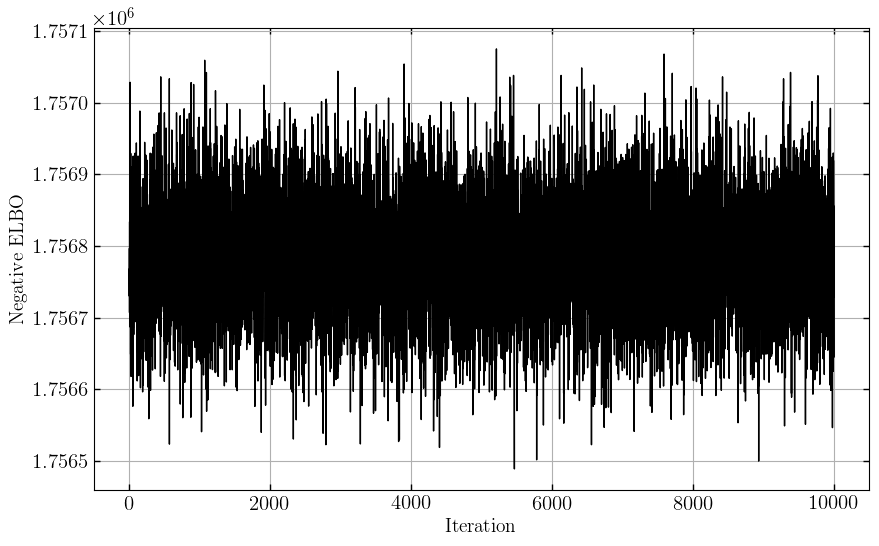

In [11]:
print(svi_results.losses[-1])
plt.figure(figsize=(10,6))
plt.plot(svi_results.losses, lw=1)
# plt.xscale('log')
# plt.ylim(1.756e6, 1.76e6)
plt.xlabel('Iteration') ; plt.ylabel('Negative ELBO')
plt.grid()
plt.show()

Instead of taking the mean, I can just take the autoloc and convert that to the contrained space.

In [12]:
auto_loc_params_ = {}
for key, val in svi_results.params.items():
    if "auto_scale" in key:
        auto_loc_params_[key] = val/1e10
    else:
        auto_loc_params_[key] = val
# auto_loc_params_ = {key: val/1e10 for key, val in svi_results.params.items() if "auto_scale" in key}
pred_dist_auto_loc = Predictive(guide, params=auto_loc_params_, num_samples=1)
pars_auto_loc_ = pred_dist_auto_loc(jax.random.PRNGKey(12345), data=run_data)
pars_auto_loc = {k: jnp.median(v, axis=0) for k, v in pars_auto_loc_.items() if (k != '_auto_latent' and k != 'mixture:modeldata')}
best_params = mm.expand_numpyro_params(pars_auto_loc)

In [13]:
pred_dist = Predictive(guide, params=svi_results.params, num_samples=1_000)
pars_ = pred_dist(jax.random.PRNGKey(12345), data=run_data)
pars = mm.expand_numpyro_params(pars_)

#### Other ways to get best params

In [442]:
ns=10000
pred_dist1 = Predictive(guide, params=svi_results.params, num_samples=ns)
pars1_ = pred_dist1(rng_key=jax.random.PRNGKey(12345), data=run_data)

print('Starting iteration...')
best_ld = -np.inf
for i in range(ns):
    pars1 = {k: v[i] for k, v, in pars1_.items()}
    logprob1, _ = numpyro.infer.util.log_density(mm, model_args=(), model_kwargs={'data': run_data, 'err':run_data_err}, params=pars1)
    if logprob1 > best_ld:
        best_ld = logprob1
        print(best_ld, i)
    elif i%100 == 0:
        print(i)

Starting iteration...
-895859.523730631 0
-895606.9075337832 10
-895547.5823577119 20
-895178.1380188756 33
-894981.7845089284 78
100
200
-894932.2190580895 202
-894884.8490726729 212
-894730.593669903 252
300
400
-894693.5693955331 407
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
-894666.0709492041 5226
5300
-894518.1736668579 5318
5400
5500
5600
5700
5800
5900
6000
-894322.6779253614 6027
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900


In [443]:
best_params_ = {}
for key in pars_.keys():
    best_params_[key] = pars_[key][6027]
best_params = mm.expand_numpyro_params(best_params_)

In [63]:
MAP_p_expanded = best_params

#### Using the best params

In [14]:
# check that this sums to 1
best_params['stream']['phi1']['mixing_distribution'].sum()

Array(1., dtype=float64)

In [15]:
offtrack_phi1_dx, offtrack_phi2_dx = offtrack_dx

phi1_lim = coord_bounds['phi1']
phi2_lim = coord_bounds['phi2']

offtrack_phi12_locs = jnp.stack(
jnp.meshgrid(
    jnp.arange(phi1_lim[0]+offtrack_phi1_dx, 
               phi1_lim[1]-offtrack_phi1_dx/2 + 1e-3, #factor of two added by hand to make sure the high phi1 edge is properly included
               offtrack_phi1_dx),
    jnp.arange(phi2_lim[0]+offtrack_phi2_dx, 
               phi2_lim[1]-offtrack_phi2_dx/2 + 1e-3, 
               offtrack_phi2_dx),
),
axis=-1,
).reshape(-1, 2)

In [165]:
phi2_track_tbl = at.QTable([mm['stream'].coord_parameters['phi2']['knots']*u.deg, best_params['stream']['phi2']['loc_vals']*u.deg], names=['phi1', 'phi2'])
phi2_width_tbl = at.QTable([mm['stream'].coord_parameters['phi2']['knots']*u.deg, best_params['stream']['phi2']['scale_vals']*u.deg], names=['phi1', 'phi2_width'])
pm1_track_tbl = at.QTable([mm['stream'].coord_parameters['pm1']['knots']*u.deg, best_params['stream']['pm1']['loc_vals']*u.mas/u.yr], names=['phi1', 'pm1'])
pm1_width_tbl = at.QTable([mm['stream'].coord_parameters['pm1']['knots']*u.deg, best_params['stream']['pm1']['scale_vals']*u.mas/u.yr], names=['phi1', 'pm1_width'])
pm2_track_tbl = at.QTable([mm['stream'].coord_parameters['pm2']['knots']*u.deg, best_params['stream']['pm2']['loc_vals']*u.mas/u.yr], names=['phi1', 'pm2'])
pm2_width_tbl = at.QTable([mm['stream'].coord_parameters['pm2']['knots']*u.deg, best_params['stream']['pm2']['scale_vals']*u.mas/u.yr], names=['phi1', 'pm2_width'])
rv_track_tbl = at.QTable([mm['stream'].coord_parameters['rv']['knots']*u.deg, best_params['stream']['rv']['loc_vals']*u.km/u.s], names=['phi1', 'rv'])
rv_width_tbl = at.QTable([mm['stream'].coord_parameters['rv']['knots']*u.deg, best_params['stream']['rv']['scale_vals']*u.km/u.s], names=['phi1', 'rv_width'])

In [170]:
phi2_track_tbl.write('../../data/kinematic_tracks/phi2_track.fits')
phi2_width_tbl.write('../../data/kinematic_tracks/phi2_width.fits')

pm1_track_tbl.write('../../data/kinematic_tracks/pm1_track.fits')
pm1_width_tbl.write('../../data/kinematic_tracks/pm1_width.fits')

pm2_track_tbl.write('../../data/kinematic_tracks/pm2_track.fits')
pm2_width_tbl.write('../../data/kinematic_tracks/pm2_width.fits')

rv_track_tbl.write('../../data/kinematic_tracks/rv_track.fits')
rv_width_tbl.write('../../data/kinematic_tracks/rv_width.fits')

(-100.0, 20.0)

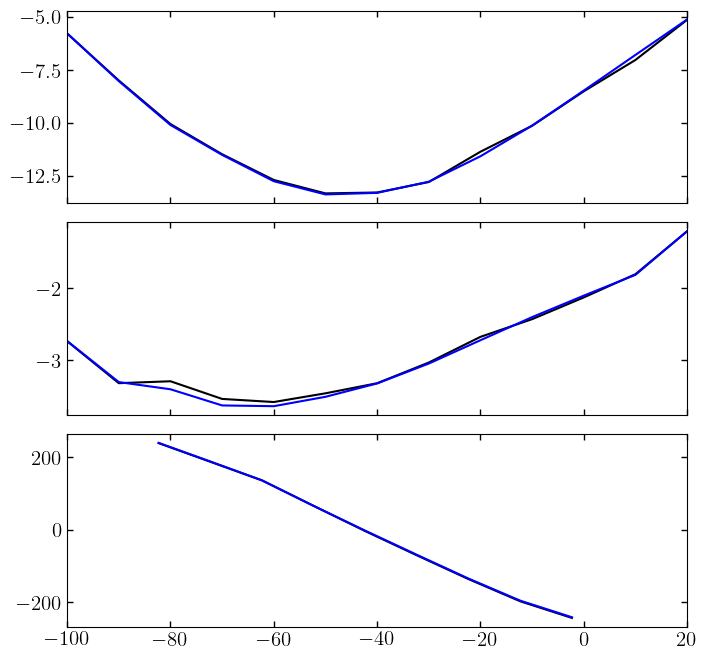

In [16]:
fig, [ax1, ax2, ax3] = plt.subplots(3,1,figsize=(8,8), sharex=True)
ax1.plot(mm['offtrack'].coord_parameters['pm1']['knots'], best_params['offtrack']['pm1']['loc_vals'])
ax1.plot(mm['stream'].coord_parameters['pm1']['knots'], best_params['stream']['pm1']['loc_vals'])

ax2.plot(mm['offtrack'].coord_parameters['pm2']['knots'], best_params['offtrack']['pm2']['loc_vals'])
ax2.plot(mm['stream'].coord_parameters['pm2']['knots'], best_params['stream']['pm2']['loc_vals'])

ax3.plot(mm['offtrack'].coord_parameters['rv']['knots'], best_params['offtrack']['rv']['loc_vals'])
ax3.plot(mm['stream'].coord_parameters['rv']['knots'], best_params['stream']['rv']['loc_vals'])
ax3.set_xlim(-100,20)

In [17]:
print(best_params['mixture-probs'])

[0.98380298 0.01506516 0.00113187]


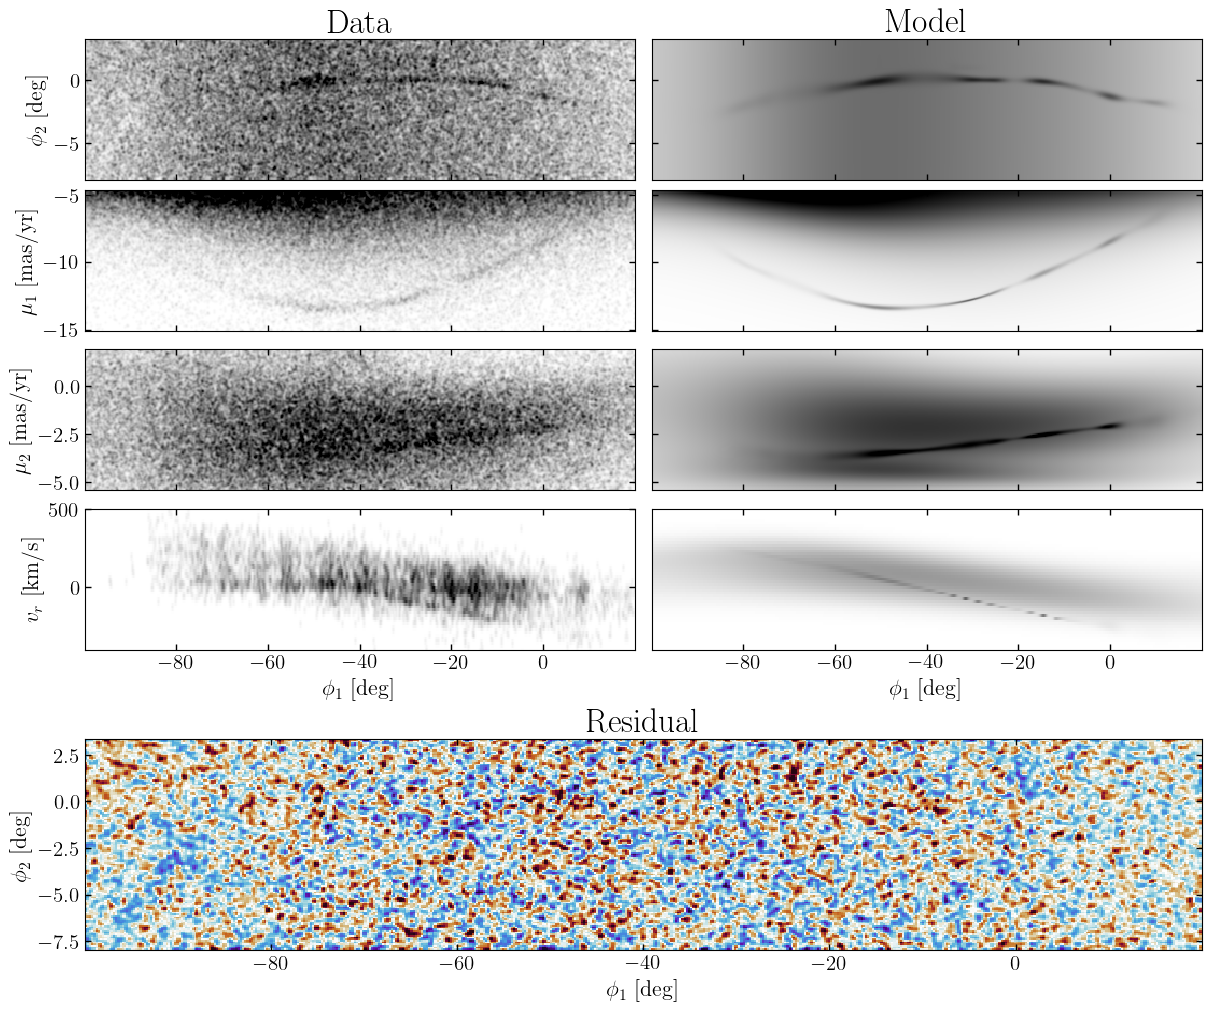

In [18]:
cmap='gray_r'
fig = plt.figure(figsize=(12, 10), constrained_layout=True)
gs = gridspec.GridSpec(5, 2, height_ratios=[1, 1, 1, 1, 1.5], figure=fig, hspace=0, wspace=0)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1], sharex=ax1, sharey=ax1)
ax3 = fig.add_subplot(gs[1, 0], sharex=ax1)
ax4 = fig.add_subplot(gs[1, 1], sharex=ax1, sharey=ax3)
ax5 = fig.add_subplot(gs[2, 0], sharex=ax1)
ax6 = fig.add_subplot(gs[2, 1], sharex=ax1, sharey=ax5)
ax7 = fig.add_subplot(gs[3, 0], sharex=ax1)
ax8 = fig.add_subplot(gs[3, 1], sharex=ax1, sharey=ax7)

ax9 = fig.add_subplot(gs[4, :], sharex=ax1)

plot_data_projections(
    data=run_data,
    grids=plot_grids,
    axes=ax3,
    coord_names=[('phi1', 'pm1')],
    pcolormesh_kwargs=dict(rasterized=True, vmax=5, vmin=0, cmap=cmap)
)
plot_data_projections(
    data=run_data,
    grids=plot_grids,
    axes=[ax1, ax5],
    pcolormesh_kwargs=dict(rasterized=True, vmax=3, vmin=0, cmap=cmap),
    coord_names=[('phi1', 'phi2'), ('phi1', 'pm2')]
)
plot_data_projections(
    data=only_rv_run_data,
    grids=plot_grids,
    axes=ax7,
    pcolormesh_kwargs=dict(rasterized=True, vmax=3, vmin=0, cmap=cmap),
    coord_names=[('phi1', 'rv')]
)

mm.plot_model_projections(ndata=len(run_data_), grids=plot_grids, 
                          grid_coord_names=[('phi1', 'phi2'), ('phi1', 'pm1')],
                          pars=best_params, axes=[ax2,ax4], label=False,
                          pcolormesh_kwargs=dict(rasterized=True, vmax=5, vmin=0, cmap=cmap))
mm.plot_model_projections(ndata=len(run_data_['rv'][run_data_['rv']!=0]), grids=plot_grids, grid_coord_names=[('phi1', 'phi2'), ('phi1', 'rv')],
                          pars=best_params, axes=[ax2,ax8], label=False,
                          pcolormesh_kwargs=dict(rasterized=True, vmax=3, vmin=0, cmap=cmap))
mm.plot_model_projections(ndata=len(run_data_), grids=plot_grids, grid_coord_names=[('phi1', 'phi2'), ('phi1', 'pm2')],
                          pars=best_params, axes=[ax2,ax6], label=False,
                          pcolormesh_kwargs=dict(rasterized=True, vmax=3, vmin=0, cmap=cmap))

mm.plot_residual_projections(
    grids=plot_grids, pars=best_params,
    data=run_data, axes=ax9, label=True, 
    pcolormesh_kwargs=dict(vmin=-1, vmax=1, rasterized=True, cmap=cmr.fusion),
    grid_coord_names=[('phi1', 'phi2')]
)

for ax in [ax1,ax2,ax3,ax4,ax5,ax6]:
    ax.label_outer()
ax8.yaxis.set_visible(False)
ax8.set_ylim(-400,500)

ax3.set_ylabel(r'$\mu_1$ [mas/yr]')
ax5.set_ylabel(r'$\mu_2$ [mas/yr]')

ax1.set_title('Data', fontsize=24)
ax2.set_title('Model', fontsize=24)
ax9.set_title('Residual', fontsize=24, pad=5)


plt.savefig('../../paper_figures/full_model.png')
plt.savefig('../../paper_figures/full_model.pdf')
plt.show()

In [464]:
pcms2[0].get_array().data

array([[2.83669736e-04, 3.04389284e-04, 3.25927929e-04, ...,
        1.61542804e-04, 1.53243365e-04, 1.44851835e-04],
       [3.07763850e-04, 3.30013496e-04, 3.53127492e-04, ...,
        1.72132023e-04, 1.63163708e-04, 1.54112496e-04],
       [3.32780924e-04, 3.56571813e-04, 3.81269741e-04, ...,
        1.83417242e-04, 1.73717577e-04, 1.63946448e-04],
       ...,
       [2.15832101e-04, 2.29112790e-04, 2.42583457e-04, ...,
        8.75509277e-05, 8.50764803e-05, 8.25762503e-05],
       [2.04297694e-04, 2.16872643e-04, 2.29633475e-04, ...,
        8.28723964e-05, 8.06205572e-05, 7.83384859e-05],
       [1.93176150e-04, 2.05074090e-04, 2.17154017e-04, ...,
        7.87243390e-05, 7.66628797e-05, 7.45675826e-05]])

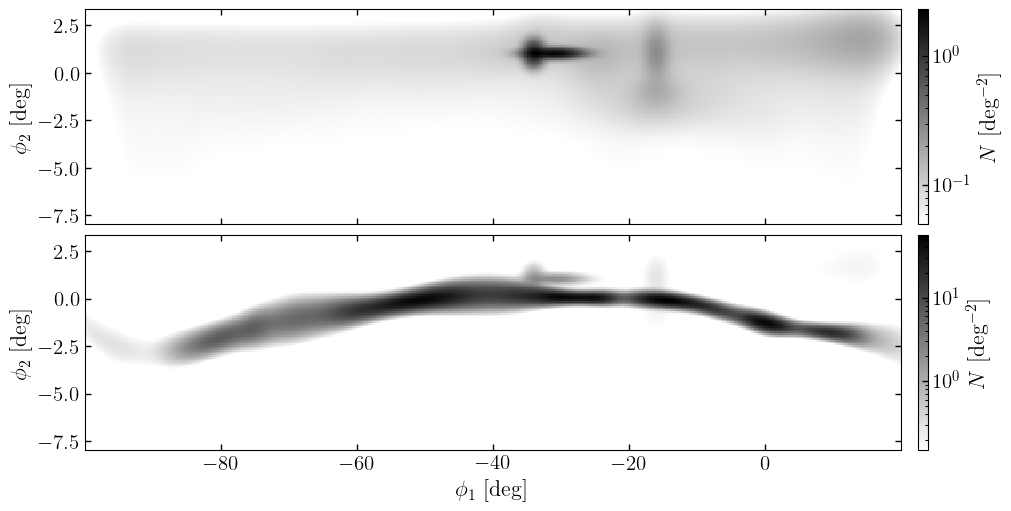

In [19]:
deltaphi1=plot_grids['phi1'][1]-plot_grids['phi1'][0]
deltaphi2=plot_grids['phi2'][1]-plot_grids['phi2'][0]

str_off_mm = ComponentMixtureModel(
    dist.Dirichlet(jnp.array([1.0, 1.0])),
    components=[mm['stream'], mm['offtrack']],
    # tied_coordinates={"offtrack": {"pm1": "stream", "pm2": "stream"}},
    )

str_off_mm_params = {
    "stream": best_params["stream"],
    "offtrack": best_params["offtrack"],
}
str_off_mm_packed_params = str_off_mm.pack_params(str_off_mm_params)
str_off_mm_packed_params["mixture-probs"] = best_params["mixture-probs"][1:] / jnp.sum(best_params["mixture-probs"][1:])
str_off_mm_packed_params["mixture"] = jnp.stack([v for v in run_data.values()], axis=-1)


fig, [ax1, ax2] = plt.subplots(2,1,figsize=(10,5), sharex=True, constrained_layout=True)
_, _, pcms1 = mm['offtrack'].plot_model_projections(ndata=len(run_data_)* best_params["mixture-probs"][2], 
                                                    grids=plot_grids, pars=best_params['offtrack'], grid_coord_names=[('phi1', 'phi2')], 
                                                    axes=ax1, pcolormesh_kwargs=dict(rasterized=True, cmap=cmap, norm=mpl.colors.LogNorm(vmin=0.001 , vmax=0.1)))
ax1.scatter(mm['offtrack'].coord_parameters[('phi1','phi2')]['locs'][0], 
            mm['offtrack'].coord_parameters[('phi1','phi2')]['locs'][1], color="tab:blue", s=3)
im1 = ax1.pcolormesh(plot_grids['phi1'], plot_grids['phi2'], pcms1[0].get_array().data/(deltaphi1*deltaphi2),
                     rasterized=True, cmap=cmap, norm=mpl.colors.LogNorm(vmin=0.05))#, norm=mpl.colors.LogNorm(vmin=0.1, vmax=100))
cbar1 = fig.colorbar(im1, ax=ax1, pad=0.02)

_, _, pcms2 = str_off_mm.plot_model_projections(ndata=len(run_data_) * jnp.sum(best_params["mixture-probs"][1:]),
                                                pars=str_off_mm_packed_params, grids=plot_grids, grid_coord_names=[('phi1', 'phi2')], axes=ax2, label=True,
                                                pcolormesh_kwargs=dict(rasterized=True, norm=mpl.colors.LogNorm(vmin=0.005), cmap=cmap))

# _, _, pcms2 = mm['stream'].plot_model_projections(ndata=len(run_data_),
#                                                 pars=MAP_p_expanded['stream'], grids=plot_grids, grid_coord_names=[('phi1', 'phi2')], axes=ax2, label=True,
#                                                 pcolormesh_kwargs=dict(rasterized=True, cmap=cmap))
im2 = ax2.pcolormesh(plot_grids['phi1'], plot_grids['phi2'], pcms2[0].get_array().data/(deltaphi1*deltaphi2),
                     rasterized=True, cmap=cmap, norm=mpl.colors.LogNorm(vmin=0.15))
cbar2 = fig.colorbar(im2, ax=ax2, pad=0.02)




ax1.set_xlabel("")
cbar1.set_label(label=r'$N$ [deg$^{-2}$]', fontsize=16)
cbar2.set_label(label=r'$N$ [deg$^{-2}$]', fontsize=16)


plt.savefig('../../paper_figures/offtrack_model.pdf')
plt.savefig('../../paper_figures/offtrack_model.png')
plt.show()

In [20]:
print(pcms1[0].get_array().sum())
print(pcms2[0].get_array().sum())

94.77986313446411
1356.2608706238498


### Make Linear Density Plot

In [21]:
stream_opt = mm['stream']
offtrack_opt = mm['offtrack']

stream_params = best_params['stream']
offtrack_params = best_params['offtrack']


grids_stream, ln_ns_stream = stream_opt.evaluate_on_2d_grids(pars=stream_params, grids=plot_grids, grid_coord_names=[("phi1", "phi2")])
grids_off, ln_ns_off = offtrack_opt.evaluate_on_2d_grids(pars=offtrack_params, grids=plot_grids, grid_coord_names=[("phi1", "phi2")])

In [22]:
str_bkg_specs = jnp.concatenate([bkg_knot_spacings, stream_knot_spacings])
# no_off_filename = svi_results_dir + 'mm_bkg{}_{}_{}_stream{}_{}_{}_{}.pkl'.format(*str_bkg_specs)
no_off_filename = svi_results_dir + 'mm_bkg{}_{}_{}_{}_stream{}_{}_{}_{}_{}.pkl'.format(*str_bkg_specs)

with open(no_off_filename, 'rb') as input_file_:
    no_off_full_dict = pickle.load(input_file_)
    
no_off_MAP_svi_results = no_off_full_dict['svi_results']
no_off_guide = no_off_full_dict['guide']

str_bkg_mm = ComponentMixtureModel(
    dist.Dirichlet(jnp.array([1.0, 1.0])),
    components=[mm['background'], mm['stream']],
)

no_off_auto_loc_params_ = {}
for key, val in no_off_MAP_svi_results.params.items():
    if "auto_scale" in key:
        no_off_auto_loc_params_[key] = val/1e10
    else:
        no_off_auto_loc_params_[key] = val
# auto_loc_params_ = {key: val/1e10 for key, val in svi_results.params.items() if "auto_scale" in key}
pred_dist_no_off_auto_loc = Predictive(no_off_guide, params=no_off_auto_loc_params_, num_samples=1)
pars_no_off_auto_loc_ = pred_dist_no_off_auto_loc(jax.random.PRNGKey(12345), data=run_data)
best_params_no_off = str_bkg_mm.expand_numpyro_params(pars_no_off_auto_loc_)

pred_dist_no_off = Predictive(no_off_guide, params=no_off_MAP_svi_results.params, num_samples=1_000)
no_off_pars_ = pred_dist_no_off(jax.random.PRNGKey(12345), data=run_data)
no_off_pars = str_bkg_mm.expand_numpyro_params(no_off_pars_)

In [23]:
deltaphi1=plot_grids['phi1'][1]-plot_grids['phi1'][0]
deltaphi2 = plot_grids['phi2'][1]-plot_grids['phi2'][0]

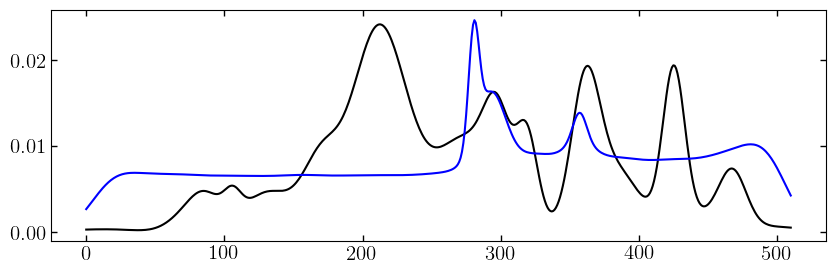

In [24]:
plt.figure(figsize=(10,3))
plt.plot(jnp.exp(ln_ns_stream[('phi1', 'phi2')]).sum(axis=0)*deltaphi2)
plt.plot(jnp.exp(ln_ns_off[('phi1', 'phi2')]).sum(axis=0)*deltaphi2)
plt.show()

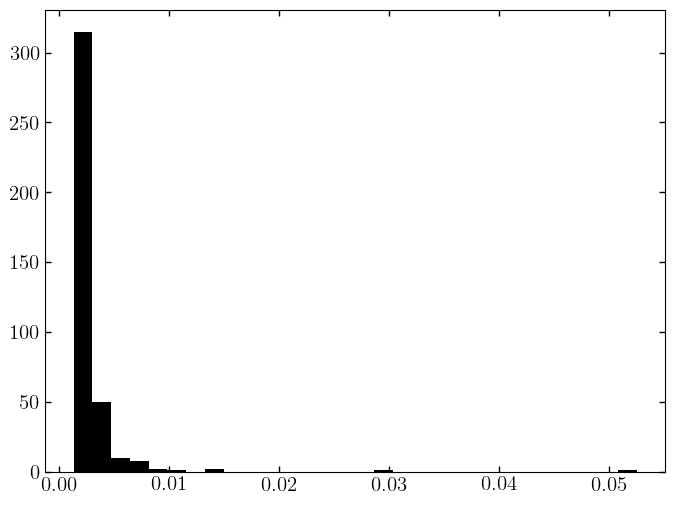

In [25]:
plt.hist(best_params['offtrack'][('phi1','phi2')]['mixing_distribution'], bins=30)
plt.show()

In [26]:
stream_lin_dens0 = (jnp.exp(ln_ns_stream[('phi1', 'phi2')]).sum(axis=0) * deltaphi2)
off_lin_dens0 = (jnp.exp(ln_ns_off[('phi1', 'phi2')]).sum(axis=0) * deltaphi2)

In [149]:
phi1s = grids_stream[('phi1','phi2')][0][0][1:] - 0.1
phi1s_rv = phi1s[(phi1s>-82)&(phi1s<3)]
ndata = len(run_data_)

deltaphi1=plot_grids['phi1'][1]-plot_grids['phi1'][0]
deltaphi2 = plot_grids['phi2'][1]-plot_grids['phi2'][0]
stream_lin_dens = ndata*best_params['mixture-probs'][1] * jnp.exp(ln_ns_stream[('phi1', 'phi2')]).sum(axis=0) * deltaphi2
off_lin_dens = ndata*best_params['mixture-probs'][2] * jnp.exp(ln_ns_off[('phi1', 'phi2')]).sum(axis=0) * deltaphi2


phi2_track = IUS(stream_opt.coord_parameters['phi2']['knots'], stream_params['phi2']['loc_vals'])
phi2_width = IUS(stream_opt.coord_parameters['phi2']['knots'], stream_params['phi2']['scale_vals'])

stream_pm1_track = IUS(stream_opt.coord_parameters['pm1']['knots'], jnp.percentile(pars_['stream:pm1:loc_vals'], 50, axis=0))
stream_pm1_track_low = IUS(stream_opt.coord_parameters['pm1']['knots'], jnp.percentile(pars_['stream:pm1:loc_vals'], 16, axis=0))
stream_pm1_track_high = IUS(stream_opt.coord_parameters['pm1']['knots'], jnp.percentile(pars_['stream:pm1:loc_vals'], 84, axis=0))
stream_pm1_width = IUS(stream_opt.coord_parameters['pm1']['knots'], stream_params['pm1']['scale_vals'])
stream_pm2_track = IUS(stream_opt.coord_parameters['pm2']['knots'], stream_params['pm2']['loc_vals'])
stream_pm2_track_low = IUS(stream_opt.coord_parameters['pm2']['knots'], jnp.percentile(pars_['stream:pm2:loc_vals'], 16, axis=0))
stream_pm2_track_high = IUS(stream_opt.coord_parameters['pm2']['knots'], jnp.percentile(pars_['stream:pm2:loc_vals'], 84, axis=0))
stream_pm2_width = IUS(stream_opt.coord_parameters['pm2']['knots'], stream_params['pm2']['scale_vals'])
stream_rv_track = IUS(stream_opt.coord_parameters['rv']['knots'], stream_params['rv']['loc_vals'])
stream_rv_track_low = IUS(stream_opt.coord_parameters['rv']['knots'], jnp.percentile(pars_['stream:rv:loc_vals'], 16, axis=0))
stream_rv_track_high = IUS(stream_opt.coord_parameters['rv']['knots'], jnp.percentile(pars_['stream:rv:loc_vals'], 84, axis=0))
stream_rv_width = IUS(stream_opt.coord_parameters['rv']['knots'], stream_params['rv']['scale_vals'])

offtrack_pm1_track = IUS(stream_opt.coord_parameters['pm1']['knots'], offtrack_params['pm1']['loc_vals'])
offtrack_pm1_track_low = IUS(stream_opt.coord_parameters['pm1']['knots'], jnp.percentile(pars_['offtrack:pm1:loc_vals'], 16, axis=0))
offtrack_pm1_track_high = IUS(stream_opt.coord_parameters['pm1']['knots'], jnp.percentile(pars_['offtrack:pm1:loc_vals'], 84, axis=0))
offtrack_pm1_width = IUS(stream_opt.coord_parameters['pm1']['knots'], offtrack_params['pm1']['scale_vals'])
offtrack_pm2_track = IUS(stream_opt.coord_parameters['pm2']['knots'], offtrack_params['pm2']['loc_vals'])
offtrack_pm2_track_low = IUS(stream_opt.coord_parameters['pm2']['knots'], jnp.percentile(pars_['offtrack:pm2:loc_vals'], 16, axis=0))
offtrack_pm2_track_high = IUS(stream_opt.coord_parameters['pm2']['knots'], jnp.percentile(pars_['offtrack:pm2:loc_vals'], 84, axis=0))
offtrack_pm2_width = IUS(stream_opt.coord_parameters['pm2']['knots'], offtrack_params['pm2']['scale_vals'])
offtrack_rv_track = IUS(stream_opt.coord_parameters['rv']['knots'], offtrack_params['rv']['loc_vals'])
offtrack_rv_track_low = IUS(stream_opt.coord_parameters['rv']['knots'], jnp.percentile(pars_['offtrack:rv:loc_vals'], 16, axis=0))
offtrack_rv_track_high = IUS(stream_opt.coord_parameters['rv']['knots'], jnp.percentile(pars_['offtrack:rv:loc_vals'], 84, axis=0))
offtrack_rv_width = IUS(stream_opt.coord_parameters['rv']['knots'], offtrack_params['rv']['scale_vals'])

phi2_width_no_off = IUS(stream_opt.coord_parameters['phi2']['knots'], best_params_no_off['stream']['phi2']['scale_vals'])

In [28]:
import astropy.coordinates as coord
import gala.coordinates as gc

m67_gd1_coord = coord.SkyCoord(ra="8h51m17s", dec="+11d48m0s", frame=coord.ICRS).transform_to(gc.GD1Koposov10)

In [29]:
#Ibata+20 predicts and Ibata+24 plots convinvingly (Figure 22) epicyclic density peaks every 2.64 kpc. 
#  Using this does not line up with the peaks in panel 1 below. 
#  However, if our distance track is low by 0.8 kpc consistently (unlikely) or if the epicyclic overdensities are instead 2.42 kpc apart, we get excellent agreement with the observed peaks

## Idea: place a vertical line at the highest density place
initial_phi1 = phi1s[np.argmax(stream_lin_dens)]
epi_sep = 2.4

# Define the distance modulus relation and correct distance in kpc
def distance_modulus(phi1):
    return 0.000244 * phi1**2 + 0.0244 * phi1 + 14.980

def distance_kpc(phi1):
    m_minus_M = distance_modulus(phi1)
    return 10**((m_minus_M + 5) / 5) / 1000 #+0.8

# Define the grid for phi1 and calculate distances
distances_kpc = distance_kpc(phi1s)  # Compute distances in kpc

# Compute arc length increments and cumulative arc length
distances_gradient = np.gradient(distances_kpc, phi1s) * (np.pi / 180)  # Gradient in radians
arc_length_increment = distances_kpc * np.sqrt(1 + distances_gradient**2) * np.gradient(phi1s) * np.pi / 180
cumulative_arc_length = np.cumsum(arc_length_increment)

# Interpolate cumulative arc length to phi1
from scipy.interpolate import interp1d
arc_length_interp = interp1d(cumulative_arc_length, phi1s, kind="linear", fill_value="extrapolate")

initial_arc_length = np.interp(initial_phi1, phi1s, cumulative_arc_length)

# Compute arc lengths for density peaks, both forward and backward
density_peak_arc_lengths = [initial_arc_length]
while density_peak_arc_lengths[-1] + epi_sep < cumulative_arc_length[-1]:
    density_peak_arc_lengths.append(density_peak_arc_lengths[-1] + epi_sep)

while density_peak_arc_lengths[0] - epi_sep > cumulative_arc_length[0]:
    density_peak_arc_lengths.insert(0, density_peak_arc_lengths[0] - epi_sep)

# Map arc lengths to phi1 positions
density_peaks_phi1 = arc_length_interp(density_peak_arc_lengths)
print(density_peaks_phi1)

[-84.95457888 -68.00879603 -49.84615011 -31.70322221 -14.80774355
   0.11283373  12.89858815]


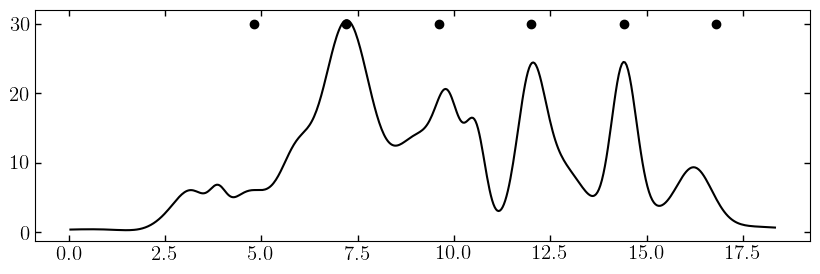

In [30]:
plt.figure(figsize=(10,3))
plt.plot(np.cumsum(arc_length_increment), stream_lin_dens)
plt.scatter(jnp.array([5,7.4, 9.8,12.2,14.6,17])-0.2,jnp.array([30,30,30,30,30,30]))
plt.show()

In [31]:
physical_scale_spline = IUS(np.cumsum(arc_length_increment), stream_lin_dens, k=3)
xs = np.linspace(0,18.3,10000)
stream_physical_scale_dens = physical_scale_spline(xs)

def calculate_power_spectrum(x, y):
    """
    Calculate the power spectrum of a given curve defined by x and y values.

    Parameters:
        x (array-like): The x-values of the curve (e.g., time or spatial coordinates).
        y (array-like): The y-values of the curve (e.g., density or intensity).

    Returns:
        frequencies (ndarray): The frequencies corresponding to the power spectrum.
        power_spectrum (ndarray): The power spectrum values.
    """
    # Ensure x and y are numpy arrays
    x = np.asarray(x)
    y = np.asarray(y)

    # Compute the sampling interval (assumes uniform spacing)
    dx = np.mean(np.diff(x))

    # Perform the Fast Fourier Transform (FFT)
    fft_result = np.fft.fft(y)

    # Compute the frequencies
    frequencies = np.fft.fftfreq(len(y), d=dx)

    # Compute the power spectrum (magnitude squared of FFT)
    power_spectrum = np.abs(fft_result)**2

    # Return only the positive frequencies and corresponding power spectrum
    positive_frequencies = frequencies[:len(frequencies)//2]
    positive_power_spectrum = power_spectrum[:len(power_spectrum)//2]

    return positive_frequencies, positive_power_spectrum

/var/folders/f1/wqzqbly11d9__jf5mjckhwvm0000gq/T/ipykernel_78086/1117561592.py:6: RuntimeWarning: divide by zero encountered in divide
  plt.plot(np.linspace(1,7,1000), IUS(np.flip(1/frequencies)[4980:-1], np.flip(power_spectrum[1:-4980]),k=3)(np.linspace(1,7,1000)))


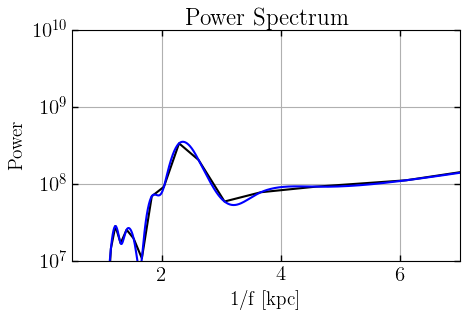

In [32]:
frequencies, power_spectrum = calculate_power_spectrum(xs, stream_physical_scale_dens)

# Plot the power spectrum
plt.figure(figsize=(5, 3))
plt.semilogy(1/frequencies[1:], power_spectrum[1:])
plt.plot(np.linspace(1,7,1000), IUS(np.flip(1/frequencies)[4980:-1], np.flip(power_spectrum[1:-4980]),k=3)(np.linspace(1,7,1000)))
plt.xlim(0.5, 7)
plt.ylim(1e7,1e10)
plt.title('Power Spectrum')
plt.xlabel('1/f [kpc]')
plt.ylabel('Power')
plt.grid()
plt.show()

In [33]:
import scipy
scipy.optimize.minimize_scalar(IUS(np.flip(1/frequencies)[4980:-1], -np.flip(power_spectrum[1:-4980]),k=3), bounds=[2,3], method='bounded')

/var/folders/f1/wqzqbly11d9__jf5mjckhwvm0000gq/T/ipykernel_78086/278320560.py:2: RuntimeWarning: divide by zero encountered in divide
  scipy.optimize.minimize_scalar(IUS(np.flip(1/frequencies)[4980:-1], -np.flip(power_spectrum[1:-4980]),k=3), bounds=[2,3], method='bounded')


 message: Solution found.
 success: True
  status: 0
     fun: -351062843.1372298
       x: 2.3507106508066844
     nit: 11
    nfev: 11

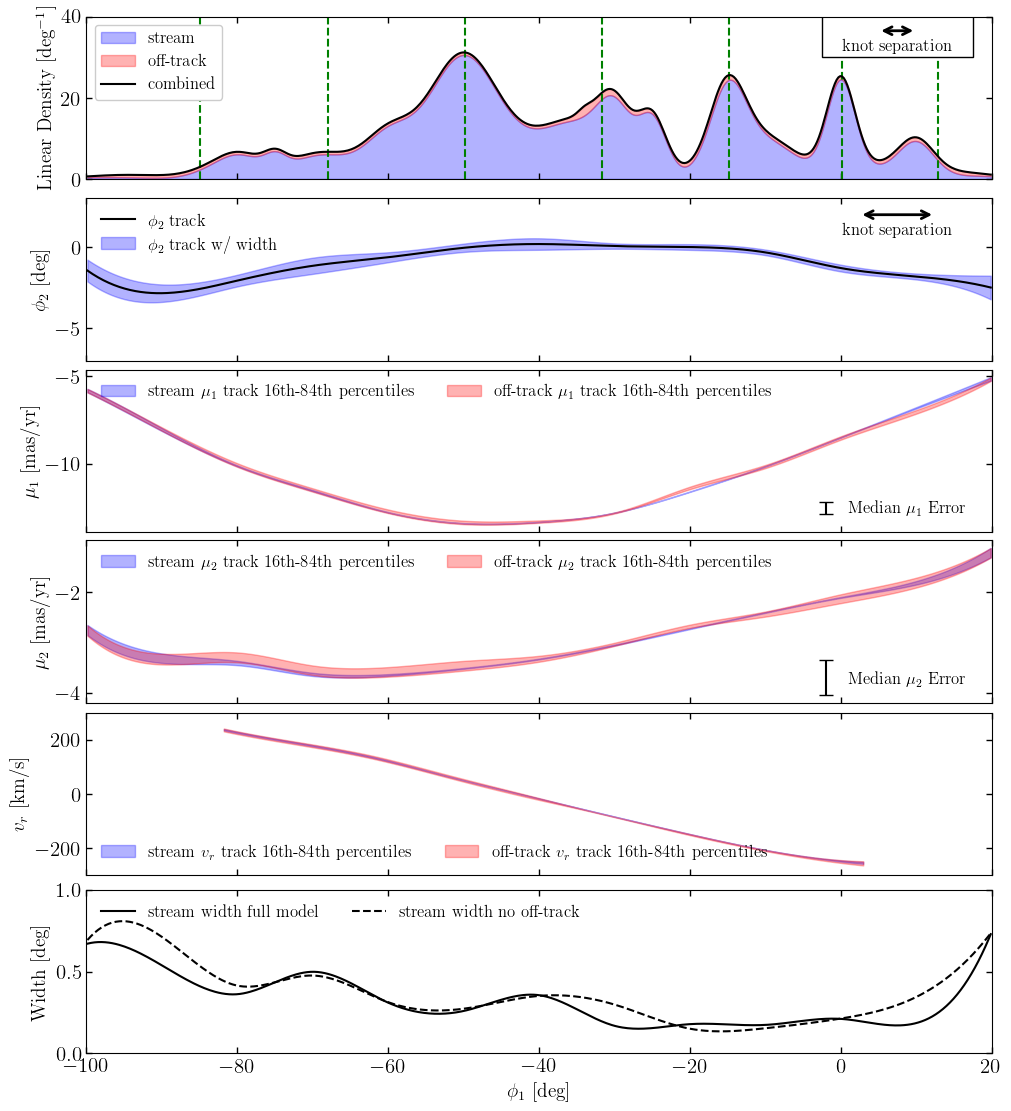

In [34]:
fig, [ax1, ax2, ax3, ax4, ax5, ax6] = plt.subplots(6, 1, figsize=(10,11), constrained_layout=True, sharex=True)
ax1.fill_between(phi1s, 0, stream_lin_dens, color='b', alpha=0.3, label=r'stream')
ax1.fill_between(phi1s, stream_lin_dens, stream_lin_dens+off_lin_dens, color='r', alpha=0.3, label=r'off-track')
for peak in density_peaks_phi1:
    ax1.axvline(peak, color='g', ls='--')
ax1.plot(phi1s, stream_lin_dens+off_lin_dens, color='k', label=r'combined')
ax1.annotate("", xy=(10,36.5), xytext=(10-stream_knot_spacings[0],36.5), arrowprops=dict(arrowstyle="<->", linewidth=2, color="black"))
magic_box1 = mpl.patches.Rectangle((7.5 - 20 / 2, 35 - 10 / 2), 20, 25, facecolor="white", edgecolor="black", linewidth=1, zorder=2)
ax1.add_patch(magic_box1)
ax1.text(10-0.5*stream_knot_spacings[0], 32.5, "knot separation", fontsize=12, ha="center", va="center")
ax1.set_ylabel(r'Linear Density [deg$^{-1}$]', fontsize=14)
ax1.set_ylim(0,40)
ax1.legend(fontsize=12, loc='upper left', frameon=True, fancybox=True, framealpha=1)

ax2.plot(phi1s, phi2_track(phi1s), c='k', label=r'$\phi_2$ track')
ax2.fill_between(phi1s, phi2_track(phi1s) - phi2_width(phi1s), phi2_track(phi1s) + phi2_width(phi1s), 
                 color='b', alpha=0.3, label=r'$\phi_2$ track w/ width')
ax2.annotate("", xy=(12.5,2), xytext=(12.5-stream_knot_spacings[1],2), arrowprops=dict(arrowstyle="<->", linewidth=2, color="black"))
ax2.text(12.5-0.5*stream_knot_spacings[1], 1, "knot separation", fontsize=12, ha="center", va="center")
ax2.set_ylim(-7, 3)
ax2.set_ylabel(r'$\phi_2$ [deg]', fontsize=14)
ax2.legend(fontsize=12, loc='upper left')

# ax3.plot(phi1s, stream_pm1_track(phi1s), c='k', label=r'stream $\mu_1$ track')
ax3.errorbar(-2, -12.5, yerr=0.35, fmt='', capsize=5, color='black')
ax3.text(1, -12.8, r'Median $\mu_1$ Error', fontsize=12)
ax3.fill_between(phi1s, stream_pm1_track_low(phi1s), stream_pm1_track_high(phi1s), 
                 color='b', alpha=0.3, label=r'stream $\mu_1$ track 16th-84th percentiles')
ax3.fill_between(phi1s, offtrack_pm1_track_low(phi1s), offtrack_pm1_track_high(phi1s), 
                 color='r', alpha=0.3, label=r'off-track $\mu_1$ track 16th-84th percentiles')
ax3.set_ylabel(r'$\mu_1$ [mas/yr]', fontsize=14)
# ax3.set_ylim(-18,-4)
ax3.legend(fontsize=12, loc='upper left', ncol=3)

# ax4.plot(phi1bs, stream_pm2_track(phi1s), c='k', label=r'stream $\mu_2$ track')
ax4.errorbar(-2, -3.7, yerr=0.35, fmt='', capsize=5, color='black')
ax4.text(1, -3.8, r'Median $\mu_2$ Error', fontsize=12)
ax4.fill_between(phi1s, stream_pm2_track_low(phi1s), stream_pm2_track_high(phi1s), 
                 color='b', alpha=0.3, label=r'stream $\mu_2$ track 16th-84th percentiles')
ax4.fill_between(phi1s, offtrack_pm2_track_low(phi1s), offtrack_pm2_track_high(phi1s), 
                 color='r', alpha=0.3, label=r'off-track $\mu_2$ track 16th-84th percentiles')
ax4.set_ylabel(r'$\mu_2$ [mas/yr]', fontsize=14)
ax4.legend(fontsize=12, loc='upper left', ncol=3)

# ax5.plot(phi1s, stream_rv_track(phi1s), c='k', label=r'stream $v_r$ track')
# ax4.errorbar(-2, -3.7, yerr=0.35, fmt='', capsize=5, color='black')
# ax4.text(1, -3.8, r'Median $\mu_{\phi_2}$ Error', fontsize=12)
ax5.fill_between(phi1s_rv, stream_rv_track_low(phi1s_rv), stream_rv_track_high(phi1s_rv),
                 color='b', alpha=0.3, label=r'stream $v_r$ track 16th-84th percentiles')
ax5.fill_between(phi1s_rv, offtrack_rv_track_low(phi1s_rv), offtrack_rv_track_high(phi1s_rv), 
                 color='r', alpha=0.3, label=r'off-track $v_r$ track 16th-84th percentiles')
ax5.set_ylabel(r'$v_r$ [km/s]', fontsize=14)
ax5.set_ylim(-300,300)
ax5.legend(fontsize=12, loc='lower left', ncol=3)

ax6.plot(phi1s, phi2_width(phi1s), c='k', label=r'stream width full model')
ax6.plot(phi1s, phi2_width_no_off(phi1s), c='k', ls='dashed', label=r'stream width no off-track')
ax6.set_ylim(0, 1)
ax6.set_ylabel(r'Width [deg]', fontsize=14)
ax6.legend(fontsize=12, loc='upper left', ncol=2)

ax6.set_xlim(-100, 20)
ax6.set_xlabel(r'$\phi_1$ [deg]', fontsize=14)

plt.savefig('../../paper_figures/stream_properties.png')
plt.savefig('../../paper_figures/stream_properties.pdf')
plt.show()

In [35]:
print(phi1s[160])
stream_lin_dens[200:-80].min()

-62.29198566795566


Array(3.03536235, dtype=float64)

In [36]:
print(jnp.median(stream_lin_dens[(phi1s<5) & (phi1s>-65)]))
print(jnp.median(stream_lin_dens[(phi1s<-65)&(phi1s>-90)]))

14.877704715908157
5.617580090032069


In [37]:
jnp.median(stream_lin_dens[(phi1s<5) & (phi1s>-65)]) / jnp.median(stream_lin_dens[(phi1s<-65)&(phi1s>-90)])

Array(2.6484188, dtype=float64)

In [38]:
all_data_ = iso_obj.cat[pm_mask]
all_data_['rv'][all_data_['rv'].mask] = 0
all_data_['rv_err'][all_data_['rv_err'].mask] = 1e4

all_data = {k: jnp.array(all_data_[k], dtype="f8") for k in all_data_.colnames}
all_data_err = {'phi1': 1e-4, 'phi2': 1e-4,
                'pm1': jnp.array(all_data_['pm1_error'], dtype="f8"),
                'pm2': jnp.array(all_data_['pm2_error'], dtype="f8"),
                'rv': jnp.array(all_data_['rv_err'], dtype="f8"),}

In [39]:
lp_dict = make_lp_dict(mm, all_data, all_data_err, best_params)

In [40]:
sum_probs = jnp.exp(lp_dict['background']) + jnp.exp(lp_dict['stream']) + jnp.exp(lp_dict['offtrack'])
memb_prob = (jnp.exp(lp_dict['stream']) + jnp.exp(lp_dict['offtrack'])) / sum_probs
print((memb_prob > 0.5).sum())
print((memb_prob > 0.75).sum())

2276
1828


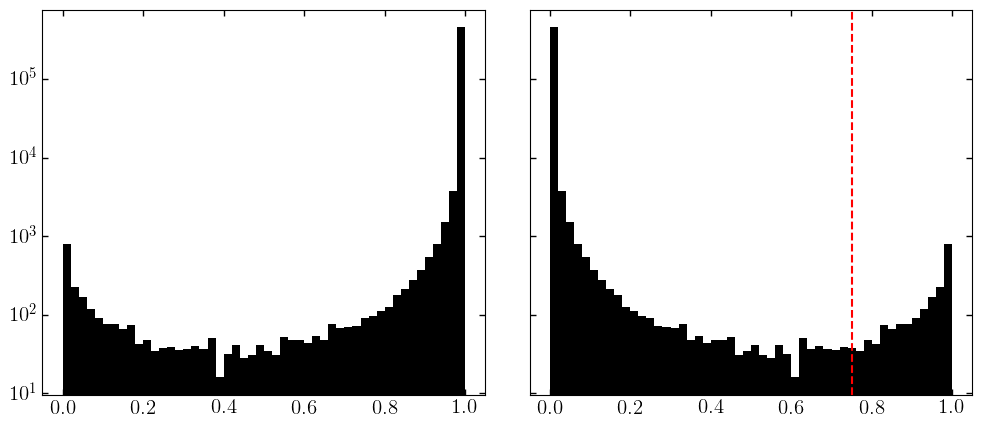

In [41]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12,5), sharey=True)
ax1.hist(jnp.exp(lp_dict['background']) / sum_probs, bins=50)
ax1.set_yscale('log')

ax2.hist(memb_prob, bins=50)
ax2.set_yscale('log')
ax2.axvline(0.75, c='r', ls='--')

plt.show()

In [48]:
memb_sel1 = np.array(memb_prob>0.5)
memb_sel2 = np.array(memb_prob>0.75)
memb_sel3 = np.array(memb_prob>0.9)

iso_obj.turnoff = 13.0
_ = iso_obj.simpleSln()
distmod_spl = np.poly1d([1/64**2, 100/64**2, (50/64)**2 +18.82-4.45])
dist_mod_shift = distmod_spl(all_data_["phi1"])

cmd_poly = iso_obj.pawprint.cmdprint.vertices - jnp.array([0,iso_obj.dist_mod])
cmd_patch = mpl.patches.Polygon(cmd_poly, facecolor="red", alpha=0.3)
hb_poly = iso_obj.pawprint.hbprint.vertices - jnp.array([0,iso_obj.dist_mod])
hb_patch = mpl.patches.Polygon(hb_poly, facecolor="red", alpha=0.3)
g_r = all_data_['g0'] - all_data_['r0']
Gmag = all_data['g0'] - dist_mod_shift

cmd_sel = np.array(cmd_patch.contains_points(np.array([g_r, Gmag]).T) | hb_patch.contains_points(np.array([g_r, Gmag]).T))

In [49]:
print(len(all_data_[memb_sel1]))
print(len(all_data_[memb_sel1&cmd_sel]))

2276
1665


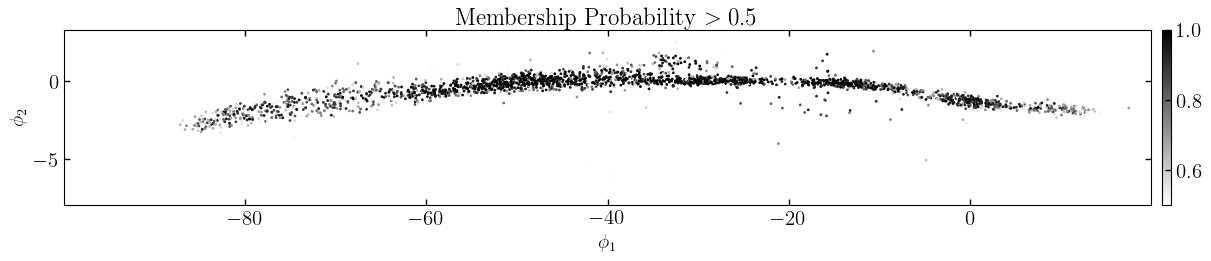

In [50]:
fig, ax1 = plt.subplots(1, 1, figsize=(12,2.5), sharex=True, sharey=True, constrained_layout=True)
im1 = ax1.scatter(all_data_[memb_sel1]['phi1'], all_data_[memb_sel1]['phi2'], c=memb_prob[memb_sel1], s=1, vmin=0.5, vmax=1, cmap='gray_r')
# ax1.scatter(all_data_[memb_sel1&bad_cmd_sel]['phi1'], all_data_[memb_sel1&bad_cmd_sel]['phi2'], s=1, c='r')
ax1.set_title(r'Membership Probability $> 0.5$')
ax1.set_xlim(coord_bounds['phi1'])
ax1.set_ylim(coord_bounds['phi2'])
ax1.set_xlabel(r'$\phi_1$')
ax1.set_ylabel(r'$\phi_2$')
cbar = fig.colorbar(im1, ax=ax1, pad=0.01)
plt.show()

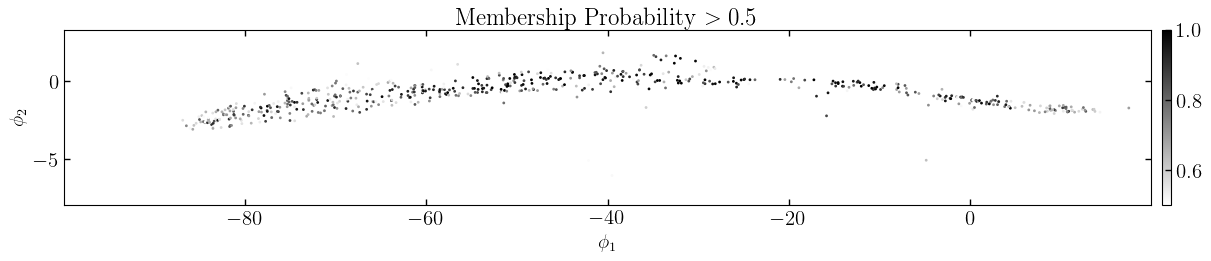

In [51]:
fig, ax1 = plt.subplots(1, 1, figsize=(12,2.5), sharex=True, sharey=True, constrained_layout=True)
im1 = ax1.scatter(all_data_[memb_sel1&~cmd_sel]['phi1'], all_data_[memb_sel1&~cmd_sel]['phi2'], c=memb_prob[memb_sel1&~cmd_sel], s=1, vmin=0.5, vmax=1, cmap='gray_r')
# ax1.scatter(all_data_[memb_sel1&bad_cmd_sel]['phi1'], all_data_[memb_sel1&bad_cmd_sel]['phi2'], s=1, c='r')
ax1.set_title(r'Membership Probability $> 0.5$')
ax1.set_xlim(coord_bounds['phi1'])
ax1.set_ylim(coord_bounds['phi2'])
ax1.set_xlabel(r'$\phi_1$')
ax1.set_ylabel(r'$\phi_2$')
cbar = fig.colorbar(im1, ax=ax1, pad=0.01)
plt.show()

In [52]:
distmod_spl = np.poly1d([2.440e-4, 2.441e-2, 14.98]) #Valluri+24
dist_mod_correct_all = distmod_spl(all_data_["phi1"]) - iso_obj.dist_mod

g = all_data_['g0'] ; r = all_data_['r0']
G = g - dist_mod_correct_all  - iso_obj.dist_mod

rrl_path = mpl.path.Path(jnp.array([[0.1,1.3], [0.1,0.2], [0.4,0.2], [0.4,1.3]]))
bhb_path = mpl.path.Path(jnp.array([[-0.4,1.3], [-0.4,0.2], [0.05,0.2], [0.05,1.3]]))
bs_path = mpl.path.Path(jnp.array([[0.15,2.3], [0.15,4.2], [-0.2,4.2], [-0.2,2.3], [0.15,2.3]]))
cmd_poly = iso_obj.pawprint.cmdprint.vertices - jnp.array([0,iso_obj.dist_mod])
cmd_path = mpl.path.Path(cmd_poly)

rrl_sel = rrl_path.contains_points(np.array([g-r, G]).T)
bhb_sel = bhb_path.contains_points(np.array([g-r, G]).T)
bs_sel = bs_path.contains_points(np.array([g-r, G]).T)
rgb_sel = cmd_path.contains_points(np.array([g-r, G]).T)

In [53]:
n_hb = (memb_sel1&(bhb_sel|rrl_sel)).sum()
n_bhb = (memb_sel1&bhb_sel).sum()
n_bs = (memb_sel1&bs_sel).sum()

In [54]:
print(n_hb, n_bhb, n_bs)

26 10 32


In [55]:
n_bs/n_hb

np.float64(1.2307692307692308)

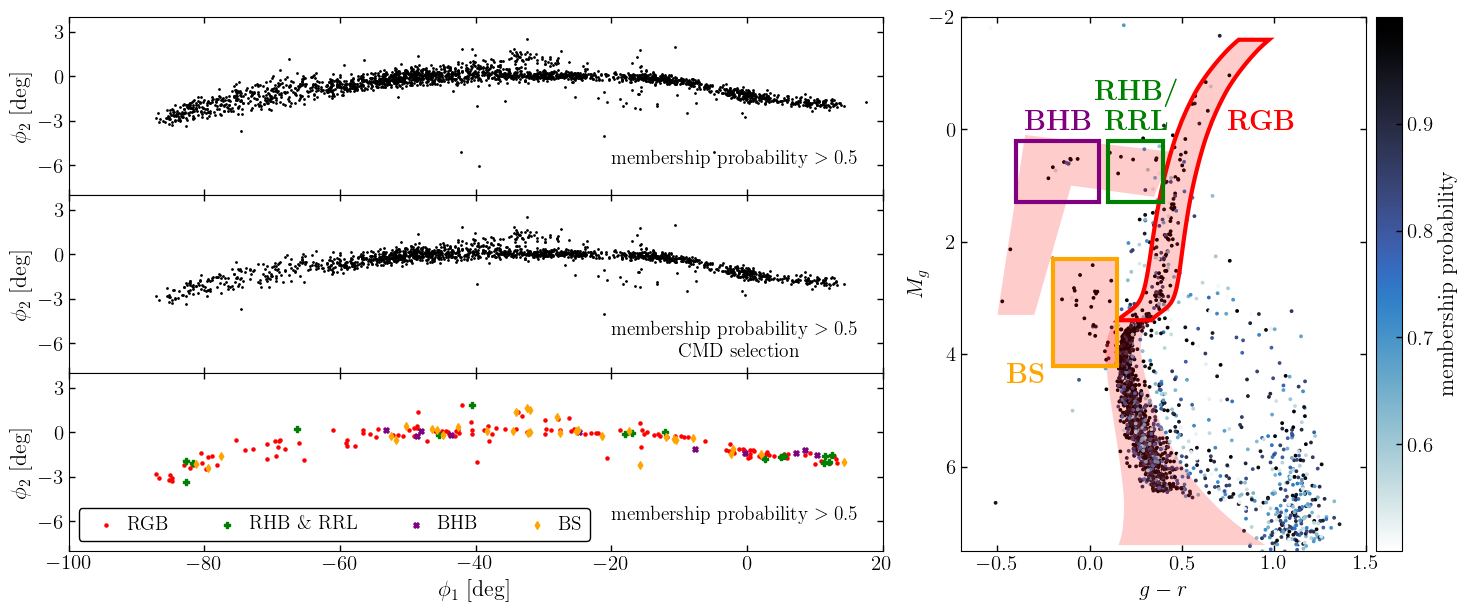

In [56]:
distmod_spl = np.poly1d([2.440e-4, 2.441e-2, 14.98]) #Valluri+24
dist_mod_correct_all = distmod_spl(all_data_[memb_sel1]["phi1"]) - iso_obj.dist_mod

from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(15,6))
gs = GridSpec(6, 2, figure=fig, width_ratios=[1, 0.6], left=0.05, right=0.97, bottom=0.09, top=0.98, wspace=0.12)
ax1 = fig.add_subplot(gs[0:2, 0])
ax2 = fig.add_subplot(gs[2:4, 0], sharey=ax1)
ax3 = fig.add_subplot(gs[4:6, 0], sharey=ax1)
ax4 = fig.add_subplot(gs[:, 1])

ax1.scatter(all_data_[memb_sel1]['phi1'], all_data_[memb_sel1]['phi2'], s=1, rasterized=True)
ax1.text(-20,-6, 'membership probability $> 0.5$', fontsize=14)
# ax1.set_title(r'Membership Probability $> 0.5$')
ax1.set_xticklabels([])
ax1.set_xlim(-100, 20)

# ax3.scatter(all_data_[memb_sel1]['phi1'], all_data_[memb_sel1]['phi2'], s=0.5, c='k', alpha=0.3)
ax2.scatter(all_data_[memb_sel1&(cmd_sel|bs_sel)]['phi1'], all_data_[memb_sel1&(cmd_sel|bs_sel)]['phi2'], s=1, c='k', rasterized=True)
ax2.text(-20,-5.5, r'membership probability $> 0.5$', fontsize=14)
ax2.text(-10,-7, 'CMD selection', fontsize=14, color='k')
ax2.set_xlim(-100, 20)
ax2.set_xticklabels([])

ax3.scatter(all_data_[memb_sel1&rgb_sel&(G<3.4)]['phi1'], all_data_[memb_sel1&rgb_sel&(G<3.4)]['phi2'], 
           c='r', marker='o', s=5, label='RGB', rasterized=True)
ax3.scatter(all_data_[memb_sel1&rrl_sel]['phi1'], all_data_[memb_sel1&rrl_sel]['phi2'], 
           c='g', marker='P', s=15, label=r'RHB \&' + ' RRL', rasterized=True)
ax3.scatter(all_data_[memb_sel1&bhb_sel]['phi1'], all_data_[memb_sel1&bhb_sel]['phi2'], 
           c='purple', marker='X', s=15, label='BHB', rasterized=True)
ax3.scatter(all_data_[memb_sel1&bs_sel]['phi1'], all_data_[memb_sel1&bs_sel]['phi2'], 
           c='orange', marker='d', s=15, label='BS', rasterized=True)
ax3.text(-20,-6, r'membership probability $> 0.5$', fontsize=14)
# ax3.text(-10,-7, 'CMD selection', fontsize=14, color='k')
ax3.set_xlim(-100, 20)
ax3.set_ylim(-8,4)
ax3.set_yticks([-6,-3,0,3])
ax3.legend(ncols=4, loc='lower left', frameon=True, fancybox=True, edgecolor='k', framealpha=1, handletextpad=0.1)

im = ax4.scatter(all_data_[memb_sel1]['g0'] - all_data_[memb_sel1]['r0'], 
            all_data_[memb_sel1]['g0'] - dist_mod_correct_all  - iso_obj.dist_mod,
            c = memb_prob[memb_sel1],
            cmap=cmr.arctic_r, s=3, rasterized=True)
cmd_patch = mpl.patches.Polygon(cmd_poly, facecolor="red", alpha=0.2)
hb_patch = mpl.patches.Polygon(hb_poly, facecolor="red", alpha=0.2)
rrl_patch = mpl.patches.Polygon(jnp.array([[0.1,1.3], [0.1,0.2], [0.4,0.2], [0.4,1.3]]), edgecolor="green", facecolor='none', lw=3)
bhb_patch = mpl.patches.Polygon(jnp.array([[-0.4,1.3], [-0.4,0.2], [0.05,0.2], [0.05,1.3]]), edgecolor="purple", facecolor='none', lw=3)
bs_patch = mpl.patches.Polygon(jnp.array([[-0.2,4.2], [-0.2,2.3], [0.15,2.3], [0.15,4.2]]), edgecolor="orange", facecolor='none', lw=3)
bs_patch2 = mpl.patches.Polygon(jnp.array([[-0.2,4.2], [-0.2,2.3], [0.15,2.3], [0.15,4.2]]), facecolor="red", alpha=0.2)
rgb_poly = cmd_poly[np.array(cmd_poly[:,1]) < 3.4]
rgb_patch = mpl.patches.Polygon(rgb_poly, edgecolor='red', facecolor='none', lw=3)
ax4.add_patch(cmd_patch) ; ax4.add_patch(hb_patch) ; ax4.add_patch(rgb_patch) ; ax4.add_patch(bs_patch2)
ax4.add_patch(rrl_patch) ; ax4.add_patch(bhb_patch) ; ax4.add_patch(bs_patch)
ax4.text(0.03,0,r'\textbf{RHB/}' + '\n' + r'\textbf{RRL}', color='green', fontsize=20, ma='center')
ax4.text(-0.35,0,r'\textbf{BHB}', color='purple', fontsize=20)
ax4.text(-0.45,4.5,r'\textbf{BS}', color='orange', fontsize=20)
ax4.text(0.75,0,r'\textbf{RGB}', color='red', fontsize=20)
ax4.set_xlabel(r'$g-r$', fontsize=16)
ax4.set_ylabel(r'$M_g$', fontsize=16, labelpad=0)
ax4.set_xlim(-0.7, 1.5)
ax4.set_ylim(7.5, -2)
cbar = fig.colorbar(im, ax=ax4, pad=0.02)
cbar.set_label('membership probability', fontsize=16)

ax1.set_ylabel(r'$\phi_2$ [deg]', fontsize=16)
ax2.set_ylabel(r'$\phi_2$ [deg]', fontsize=16)
ax3.set_ylabel(r'$\phi_2$ [deg]', fontsize=16)
ax3.set_xlabel(r'$\phi_1$ [deg]', fontsize=16)
plt.subplots_adjust(hspace=0, wspace=0.15)
plt.savefig('../../paper_figures/high_prob_members.pdf')
plt.savefig('../../paper_figures/high_prob_members.png')
plt.show()

Sanity check on the density comparison of the stream and offtrack components

/var/folders/f1/wqzqbly11d9__jf5mjckhwvm0000gq/T/ipykernel_78086/3883368471.py:10: RuntimeWarning: invalid value encountered in divide
  ax2.scatter(0.5*(bins[:-1]+bins[1:]), n2/n1, s=50, c='b', label='offtrack/stream histogram ratio')


Text(0, 0.5, 'Offtrack to stream density ratio')

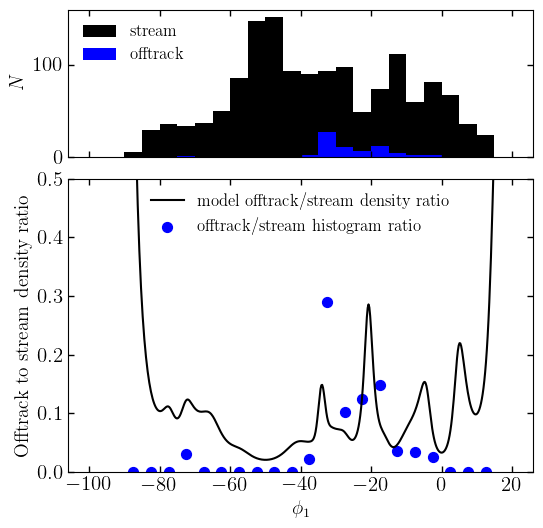

In [57]:
fig, [ax1,ax2] = plt.subplots(2,1, figsize=(6,6), gridspec_kw={'height_ratios': [1,2]}, sharex=True)
n1, bins, _ = ax1.hist(all_data_[np.array(jnp.exp(lp_dict['stream'])/sum_probs >0.5)
         &cmd_sel&(all_data_['g0']>17.8)]['phi1'], bins=24, range=[-100,20], label='stream')
n2, _, _ = ax1.hist(all_data_[np.array(jnp.exp(lp_dict['offtrack'])/sum_probs >0.5)
         &cmd_sel&(all_data_['g0']>17.8)]['phi1'], bins=24, range=[-100,20], label='offtrack')
ax1.legend(fontsize=12, loc='upper left')
ax1.set_ylabel(r'$N$')

ax2.plot(phi1s, off_lin_dens/stream_lin_dens, label='model offtrack/stream density ratio')
ax2.scatter(0.5*(bins[:-1]+bins[1:]), n2/n1, s=50, c='b', label='offtrack/stream histogram ratio')
ax2.set_ylim(0,0.5)
ax2.legend(fontsize=12, loc='upper center')
ax2.set_xlabel(r'$\phi_1$')
ax2.set_ylabel('Offtrack to stream density ratio')

Where are the off-track stars on the CMD?

(7.5, -2.0)

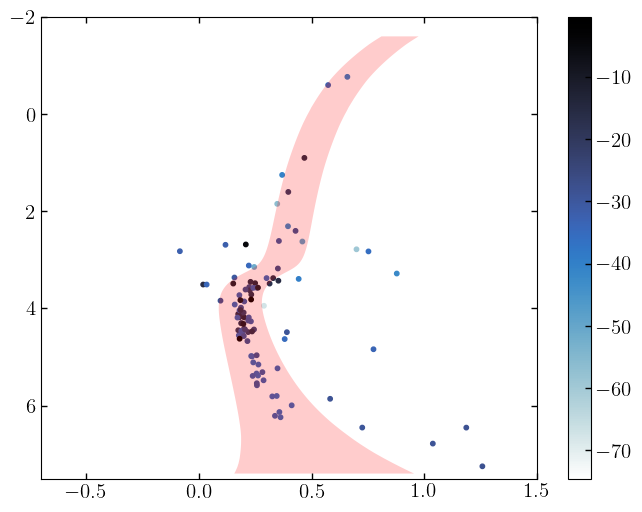

In [58]:

distmod_spl = np.poly1d([2.440e-4, 2.441e-2, 14.98]) #Valluri+24
dist_mod_correct_all2 = distmod_spl(all_data_[(all_data_['phi1']<30)][np.array(jnp.exp(lp_dict['offtrack'][(all_data_['phi1']<30)])/sum_probs[(all_data_['phi1']<30)] >0.5)]["phi1"]) - iso_obj.dist_mod

plt.scatter(all_data_[(all_data_['phi1']<30)][np.array(jnp.exp(lp_dict['offtrack'][(all_data_['phi1']<30)])/sum_probs[(all_data_['phi1']<30)] >0.5)]['g0'] - 
            all_data_[(all_data_['phi1']<30)][np.array(jnp.exp(lp_dict['offtrack'][(all_data_['phi1']<30)])/sum_probs[(all_data_['phi1']<30)] >0.5)]['r0'], 
            all_data_[(all_data_['phi1']<30)][np.array(jnp.exp(lp_dict['offtrack'][(all_data_['phi1']<30)])/sum_probs[(all_data_['phi1']<30)] >0.5)]['g0'] - dist_mod_correct_all2  - iso_obj.dist_mod,
            c = all_data_[(all_data_['phi1']<30)]['phi1'][np.array(jnp.exp(lp_dict['offtrack'][(all_data_['phi1']<30)])/sum_probs[(all_data_['phi1']<30)] >0.5)],
            cmap=cmr.arctic_r, s=10, rasterized=True)
cmd_patch2 = mpl.patches.Polygon(cmd_poly, facecolor="red", alpha=0.2)
plt.gca().add_patch(cmd_patch2)
plt.colorbar()
plt.xlim(-0.7, 1.5)
plt.ylim(7.5, -2)

In [60]:
(memb_sel1&(cmd_sel|bs_sel)).sum()

np.int64(1689)

In [145]:
all_data_['pass_CMD_cut'] = cmd_sel|bs_sel
all_data_['memb_prob'] = memb_prob
all_data_

<Table length=466571>
     source_id              ra         ... pass_CMD_cut       memb_prob       
                                       ...                                    
       int64             float64       ...     bool            float64        
------------------- ------------------ ... ------------ ----------------------
 576748068435698048 134.13841688083966 ...         True 2.2540250512219704e-93
 576748244530543488 134.16732705372561 ...        False 1.1556621439327705e-70
 576750301818727936 134.22981963824748 ...        False 1.0401231848330938e-05
 576760064280542592 134.14547166643905 ...        False  5.345798693734369e-63
 576760300502579328  134.1113034294974 ...         True 4.4983443168508237e-60
 576760334862325504 134.12016082647645 ...        False  6.697992037256874e-07
 576760437941539712  134.1564021078413 ...        False 1.6075815010313644e-17
 576760884618149248 134.16590122401283 ...        False  8.749130430123883e-26
 576761262575264896 134.04034521551716 ...        False 3.0337614857179005e-89
                ...                ... ...          ...                    ...
5763858171501338752 132.35958296457127 ...        False 1.2050217876019917e-06
5763858416314087936  132.4222150913482 ...         True  7.032152713450704e-24
5763859442811671936  132.3831513160118 ...        False  0.0003831484168580451
5763864734211393664 132.43933225841755 ...        False 1.5795746779831255e-55
5763865460060452224 132.39955636942776 ...        False  4.816227314492397e-29
5763865734938359552 132.38369519625394 ...        False  6.645660685959567e-14
5763865902442504064  132.4447438143082 ...        False  3.492834993639034e-53
5763866246039894400 132.41030567238795 ...        False  2.252654730882028e-05
5763868582502122624 132.53086892838647 ...        False 1.5645902000640071e-31

In [146]:
paper_tbl = all_data_['source_id','memb_prob','pass_CMD_cut']
paper_tbl.write('../../data/paper_table.fits', overwrite=True)

In [159]:
from astropy.io import ascii
ascii.write(paper_tbl[:10], format="latex", col_align='|lr|',
            latexdict={'preamble': r'\begin{center}',
                       'tablefoot': r'\end{center}',
                       'tabletype': 'table*'})

\begin{table*}
\begin{center}
\begin{tabular}{|lr|}
source_id & memb_prob & pass_CMD_cut \\
576748068435698048 & 2.2540250512219704e-93 & True \\
576748244530543488 & 1.1556621439327705e-70 & False \\
576750301818727936 & 1.0401231848330938e-05 & False \\
576760064280542592 & 5.345798693734369e-63 & False \\
576760300502579328 & 4.4983443168508237e-60 & True \\
576760334862325504 & 6.697992037256874e-07 & False \\
576760437941539712 & 1.6075815010313644e-17 & False \\
576760884618149248 & 8.749130430123883e-26 & False \\
576761262575264896 & 3.0337614857179005e-89 & False \\
576761644828501504 & 3.0023235176704158e-89 & False \\
\end{tabular}
\end{center}
\end{table*}


In [64]:
all_data_.write('../../data/gd1_tbl_with_memb_prob.fits', overwrite=True)

#### Check blob and spur proper motions

In [65]:
# old_tbl_ = at.Table.read('../../data/gd1_tbl_with_memb_prob.fits')
old_tbl = all_data_[(all_data_['memb_prob'] > 0.5) & all_data_['pass_CMD_cut']]

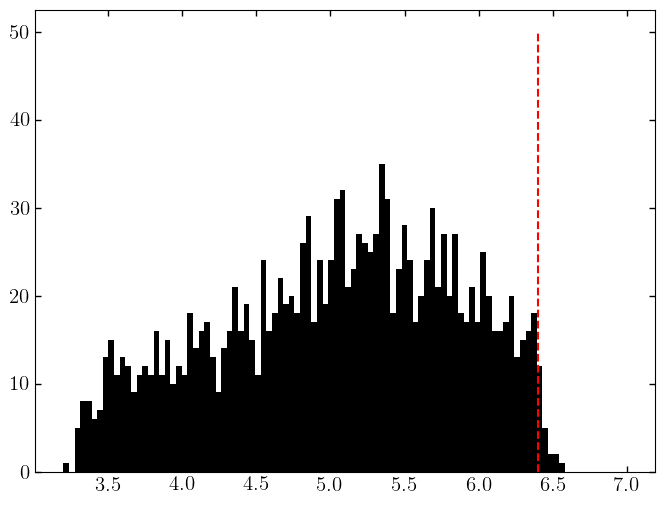

In [509]:
distmod_spl = np.poly1d([2.440e-4, 2.441e-2, 14.98]) #Valluri+24
dist_mod_correct_test = distmod_spl(old_tbl["phi1"]) - 14.59539

plt.hist(np.array(old_tbl['g0'] - dist_mod_correct_test  - 14.59539), bins=100, range=[3.2,7])
plt.vlines(6.4, 0, 50, color='r', ls='--')
plt.show()

In [510]:
blob_region = old_tbl[(old_tbl['phi1'] > -20) & (old_tbl['phi1']<-13)]
blob = old_tbl[(old_tbl['phi1'] > -20) & (old_tbl['phi1']<-10) & ((old_tbl['phi2']<-0.50) | (old_tbl['phi2']>0.30))]

spur_region = old_tbl[(old_tbl['phi1'] > -40) & (old_tbl['phi1']<-22)]
spur = old_tbl[(old_tbl['phi1'] > -40) & (old_tbl['phi1']<-22) & (old_tbl['phi2']>0.5)]

In [511]:
len(old_tbl[(old_tbl['phi1'] > -14) & (old_tbl['phi1']<-13) & (old_tbl['phi2']>-3)&(old_tbl['phi2']<2)])

36

In [512]:
len(spur)

71

In [513]:
len(spur_region)

388

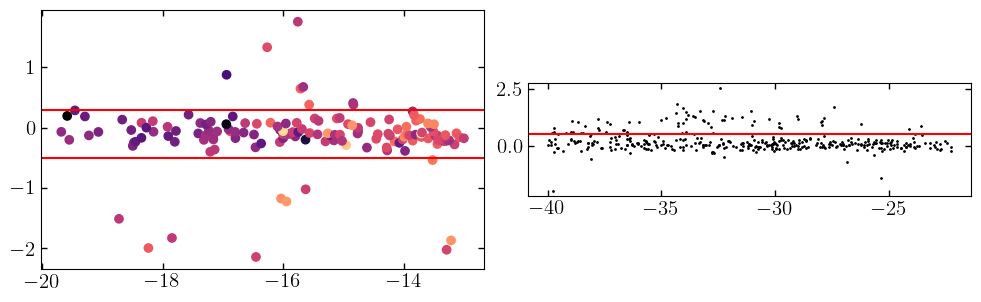

In [514]:
fig, [ax1, ax2] = plt.subplots(1,2, figsize=(12, 4))
ax1.scatter(blob_region['phi1'], blob_region['phi2'], c=blob_region['pm1'])
ax1.axhline(-0.50, color='r')
ax1.axhline(0.30, color='r')
ax1.set_aspect('equal')

ax2.scatter(spur_region['phi1'], spur_region['phi2'], c='k', s=1)
ax2.axhline(0.5, color='r')
ax2.set_aspect('equal')
plt.show()

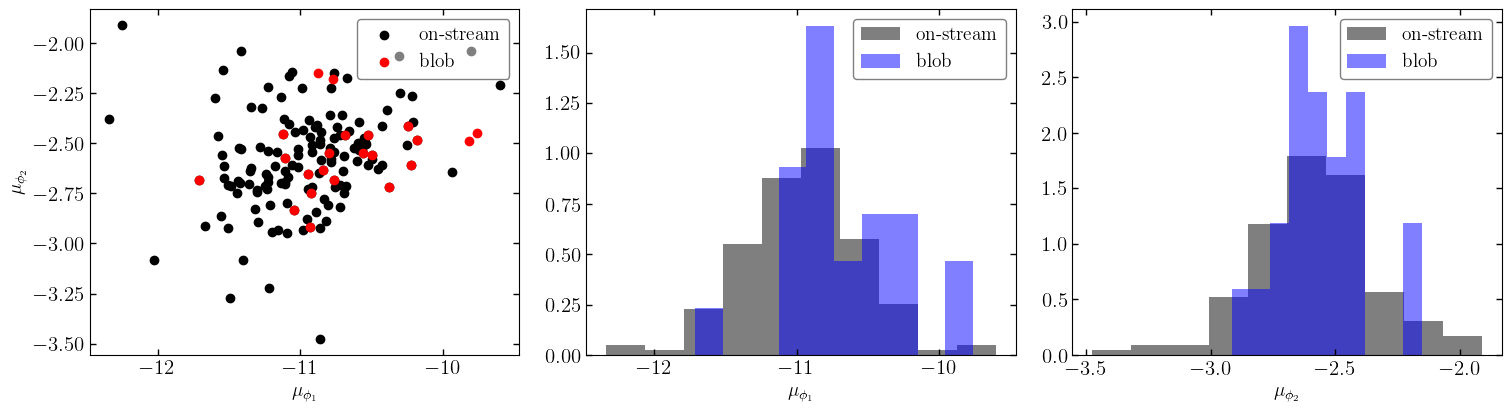

In [515]:
fig, [ax1, ax2, ax3] = plt.subplots(1,3, figsize=(15, 4), constrained_layout=True)
ax1.scatter(blob_region['pm1'], blob_region['pm2'], c='k', label='on-stream')
ax1.scatter(blob['pm1'], blob['pm2'], c='r', label='blob')
ax1.set_xlabel(r'$\mu_{\phi_1}$') ; ax1.set_ylabel(r'$\mu_{\phi_2}$')
ax1.legend(frameon=True, edgecolor='k')

ax2.hist(blob_region['pm1'], density=True, alpha=0.5, label='on-stream')
ax2.hist(blob['pm1'], density=True, alpha=0.5, label='blob')
ax2.set_xlabel(r'$\mu_{\phi_1}$')
ax2.legend(fancybox=True, frameon=True, edgecolor='k')

ax3.hist(blob_region['pm2'], density=True, alpha=0.5, label='on-stream')
ax3.hist(blob['pm2'], density=True, alpha=0.5, label='blob')
ax3.set_xlabel(r'$\mu_{\phi_2}$')
ax3.legend(fancybox=True, frameon=True, edgecolor='k')
plt.show()

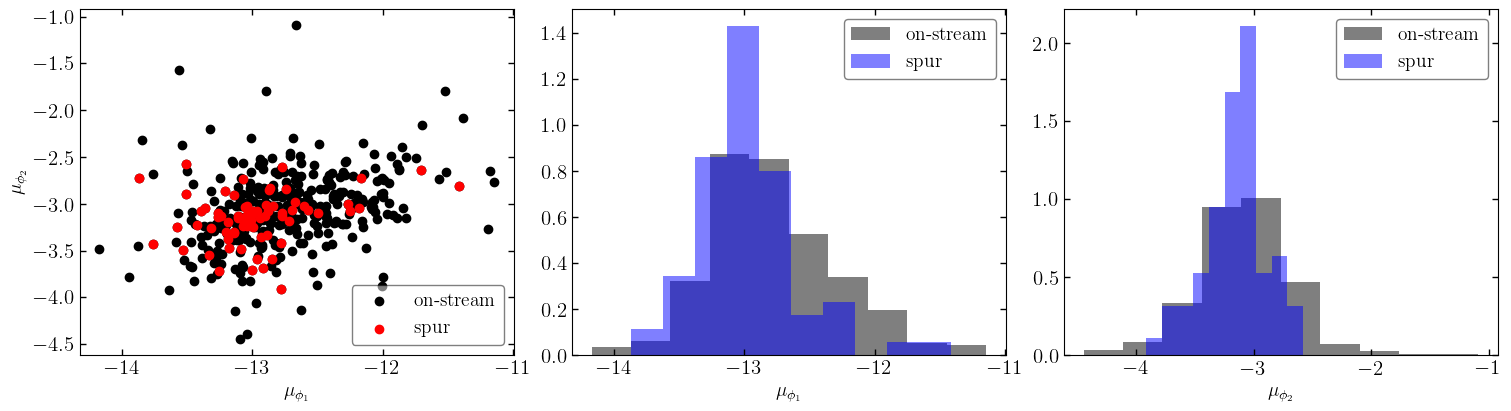

In [516]:
fig, [ax1, ax2, ax3] = plt.subplots(1,3, figsize=(15, 4), constrained_layout=True)
ax1.scatter(spur_region['pm1'], spur_region['pm2'], c='k', label='on-stream')
ax1.scatter(spur['pm1'], spur['pm2'], c='r', label='spur')
ax1.set_xlabel(r'$\mu_{\phi_1}$') ; ax1.set_ylabel(r'$\mu_{\phi_2}$')
ax1.legend(frameon=True, edgecolor='k', loc='lower right')

ax2.hist(spur_region['pm1'], density=True, alpha=0.5, label='on-stream')
ax2.hist(spur['pm1'], density=True, alpha=0.5, label='spur')
ax2.set_xlabel(r'$\mu_{\phi_1}$')
ax2.legend(fancybox=True, frameon=True, edgecolor='k')

ax3.hist(spur_region['pm2'], density=True, alpha=0.5, label='on-stream')
ax3.hist(spur['pm2'], density=True, alpha=0.5, label='spur')
ax3.set_xlabel(r'$\mu_{\phi_2}$')
ax3.legend(fancybox=True, frameon=True, edgecolor='k')
plt.show()

#### Blob/Spur Offset from Model

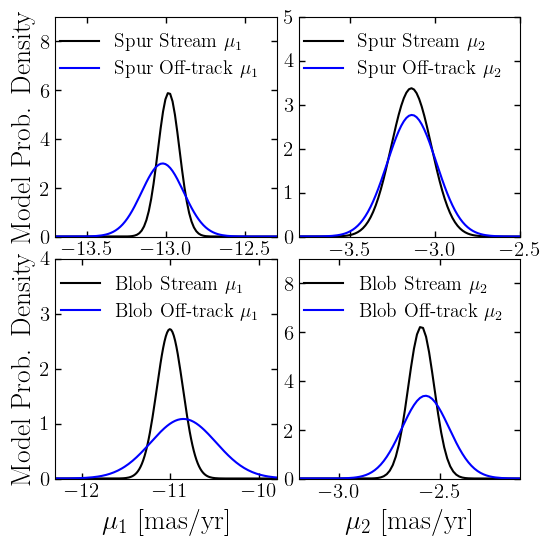

In [71]:
x = np.linspace(-15,0, 1000)
blob_loc = -16
blob_stream_pm1_mean, blob_stream_pm1_scale = stream_pm1_track(blob_loc), stream_pm1_width(blob_loc)
blob_offtrack_pm1_mean, blob_offtrack_pm1_scale = offtrack_pm1_track(blob_loc), offtrack_pm1_width(blob_loc)

blob_stream_pm2_mean, blob_stream_pm2_scale = stream_pm2_track(blob_loc), stream_pm2_width(blob_loc)
blob_offtrack_pm2_mean, blob_offtrack_pm2_scale = offtrack_pm2_track(blob_loc), offtrack_pm2_width(blob_loc)

spur_loc = -33
spur_stream_pm1_mean, spur_stream_pm1_scale = stream_pm1_track(spur_loc), stream_pm1_width(spur_loc)
spur_offtrack_pm1_mean, spur_offtrack_pm1_scale = offtrack_pm1_track(spur_loc), offtrack_pm1_width(spur_loc)

spur_stream_pm2_mean, spur_stream_pm2_scale = stream_pm2_track(spur_loc), stream_pm2_width(spur_loc)
spur_offtrack_pm2_mean, spur_offtrack_pm2_scale = offtrack_pm2_track(spur_loc), offtrack_pm2_width(spur_loc)

# Compute the probability density function (PDF)
blob_pm1_streampdf = scipy.stats.norm.pdf(x, loc=blob_stream_pm1_mean, scale=blob_stream_pm1_scale, )
blob_pm1_offtrackpdf = scipy.stats.norm.pdf(x, loc=blob_offtrack_pm1_mean, scale=blob_offtrack_pm1_scale)

blob_pm2_streampdf = scipy.stats.norm.pdf(x, loc=blob_stream_pm2_mean, scale=blob_stream_pm2_scale, )
blob_pm2_offtrackpdf = scipy.stats.norm.pdf(x, loc=blob_offtrack_pm2_mean, scale=blob_offtrack_pm2_scale)

spur_pm1_streampdf = scipy.stats.norm.pdf(x, loc=spur_stream_pm1_mean, scale=spur_stream_pm1_scale, )
spur_pm1_offtrackpdf = scipy.stats.norm.pdf(x, loc=spur_offtrack_pm1_mean, scale=spur_offtrack_pm1_scale)

spur_pm2_streampdf = scipy.stats.norm.pdf(x, loc=spur_stream_pm2_mean, scale=spur_stream_pm2_scale, )
spur_pm2_offtrackpdf = scipy.stats.norm.pdf(x, loc=spur_offtrack_pm2_mean, scale=spur_offtrack_pm2_scale)

# Plot the Gaussian
fig, [[ax3, ax4], [ax1, ax2]] = plt.subplots(2,2, figsize=(6, 6))
ax1.plot(x, blob_pm1_streampdf, label=r'Blob Stream $\mu_1$') # at phi1=-18
ax1.plot(x, blob_pm1_offtrackpdf, label=r' Blob Off-track  $\mu_1$')
ax1.set_xlim(-12.3, -9.8)
ax1.set_ylim(0,4)
ax1.set_xlabel(r'$\mu_1$ [mas/yr]', fontsize=20)
ax1.legend(fontsize=14)

ax2.plot(x, blob_pm2_streampdf, label=r'Blob Stream $\mu_2$')
ax2.plot(x, blob_pm2_offtrackpdf, label=r'Blob Off-track  $\mu_2$')
ax2.set_xlim(-3.2, -2.1)
ax2.set_ylim(0,9)
ax2.set_xlabel(r'$\mu_2$ [mas/yr]', fontsize=20)
ax2.legend(fontsize=14)

ax3.plot(x, spur_pm1_streampdf, label=r'Spur Stream $\mu_1$') # at phi1=-33
ax3.plot(x, spur_pm1_offtrackpdf, label=r'Spur Off-track  $\mu_1$')
ax3.set_xlabel(r"$\mu_1$ [mas/yr]", fontsize=20)
ax3.set_xlim(-13.7, -12.3)
ax3.set_ylim(0,9)
ax3.legend(fontsize=14)

ax4.plot(x, spur_pm2_streampdf, label=r'Spur Stream $\mu_2$')
ax4.plot(x, spur_pm2_offtrackpdf, label=r'Spur Off-track  $\mu_2$')
ax4.set_xlabel(r"$\mu_2$ [mas/yr]", fontsize=20)
ax4.set_xlim(-3.8, -2.5)
ax4.set_ylim(0,5)
ax4.legend(fontsize=14)

ax1.set_ylabel("Model Prob. Density", fontsize=20)
ax3.set_ylabel("Model Prob. Density", fontsize=20)
plt.subplots_adjust(wspace=0.1)

# plt.legend(fontsize=20)
plt.savefig('../../paper_figures/offtrack_pm_offsets.pdf')
plt.show()

In [72]:
pars_['stream:pm1:scale_vals'][0]

Array([0.1903154 , 0.48757206, 0.18073773, 0.21483024, 0.12927417,
       0.11574146, 0.1200454 , 0.05338681, 0.11599883, 0.16588024,
       0.16292715, 0.32272959, 0.87805382], dtype=float64)

Text(0.5, 0, '$\\phi_1$ [deg]')

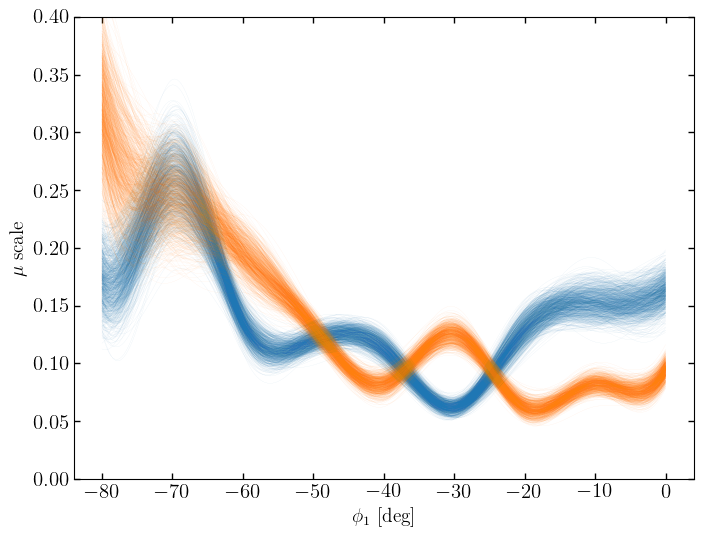

In [73]:
xgrid = np.linspace(-80, 0, 256)

for name, color in zip(["pm1", "pm2"], ["tab:blue", "tab:orange", "tab:green"]):
    spl_grid = np.zeros((pars_[f'stream:{name}:scale_vals'].shape[0], len(xgrid)))
    for i in range(pars_[f'stream:{name}:scale_vals'].shape[0]):
        spl = IUS(mm['stream'].coord_parameters[name]['knots'], pars_[f'stream:{name}:scale_vals'][i], k=3)
        spl_grid[i] = spl(xgrid)
    plt.plot(xgrid, spl_grid.T, alpha=0.2, color=color, lw=0.1);
plt.ylim(0,0.4)
plt.ylabel(r'$\mu$ scale')
plt.xlabel(r'$\phi_1$ [deg]')

In [74]:
phi1_spur = -33
phi1_blob = -16

stream_pm1_mean_cubic_spline = IUS(mm['stream'].coord_parameters['pm1']['knots'], jnp.mean(pars_['stream:pm1:loc_vals'], axis=0), k=3)
stream_pm1_scale_cubic_spline = IUS(mm['stream'].coord_parameters['pm1']['knots'], jnp.mean(pars_['stream:pm1:scale_vals'], axis=0), k=3)
stream_pm2_mean_cubic_spline = IUS(mm['stream'].coord_parameters['pm2']['knots'], jnp.mean(pars_['stream:pm2:loc_vals'], axis=0), k=3)
stream_pm2_scale_cubic_spline = IUS(mm['stream'].coord_parameters['pm2']['knots'], jnp.mean(pars_['stream:pm2:scale_vals'], axis=0), k=3)
stream_rv_mean_cubic_spline = IUS(mm['stream'].coord_parameters['rv']['knots'], jnp.mean(pars_['stream:rv:loc_vals'], axis=0), k=3)
stream_rv_scale_cubic_spline = IUS(mm['stream'].coord_parameters['rv']['knots'], jnp.mean(pars_['stream:rv:scale_vals'], axis=0), k=3)


offtrack_pm1_mean_cubic_spline = IUS(mm['stream'].coord_parameters['pm1']['knots'], jnp.mean(pars_['offtrack:pm1:loc_vals'], axis=0), k=3)
offtrack_pm1_scale_cubic_spline = IUS(mm['stream'].coord_parameters['pm1']['knots'], jnp.mean(pars_['offtrack:pm1:scale_vals'], axis=0), k=3)
offtrack_pm2_mean_cubic_spline = IUS(mm['stream'].coord_parameters['pm2']['knots'], jnp.mean(pars_['offtrack:pm2:loc_vals'], axis=0), k=3)
offtrack_pm2_scale_cubic_spline = IUS(mm['stream'].coord_parameters['pm2']['knots'], jnp.mean(pars_['offtrack:pm2:scale_vals'], axis=0), k=3)
offtrack_rv_mean_cubic_spline = IUS(mm['stream'].coord_parameters['rv']['knots'], jnp.mean(pars_['offtrack:rv:loc_vals'], axis=0), k=3)
offtrack_rv_scale_cubic_spline = IUS(mm['stream'].coord_parameters['rv']['knots'], jnp.mean(pars_['offtrack:rv:scale_vals'], axis=0), k=3)

print('Spur')
print(r'Stream $\mu_{\phi_1}$:', stream_pm1_mean_cubic_spline(phi1_spur), stream_pm1_scale_cubic_spline(phi1_spur))
print(r'Offtrack $\mu_{\phi_1}$:', offtrack_pm1_mean_cubic_spline(phi1_spur), offtrack_pm1_scale_cubic_spline(phi1_spur))
print(r'Stream $\mu_{\phi_2}$:', stream_pm2_mean_cubic_spline(phi1_spur), stream_pm2_scale_cubic_spline(phi1_spur))
print(r'Offtrack $\mu_{\phi_2}$:', offtrack_pm2_mean_cubic_spline(phi1_spur), offtrack_pm2_scale_cubic_spline(phi1_spur))
print(r'Stream $v_r$:', stream_rv_mean_cubic_spline(phi1_spur), stream_rv_scale_cubic_spline(phi1_spur))
print(r'Offtrack $v_r$:', offtrack_rv_mean_cubic_spline(phi1_spur), offtrack_rv_scale_cubic_spline(phi1_spur))
print('')

print('blob')
print(r'Stream $\mu_{\phi_1}$:', stream_pm1_mean_cubic_spline(phi1_blob), stream_pm1_scale_cubic_spline(phi1_blob))
print(r'Offtrack $\mu_{\phi_1}$:', offtrack_pm1_mean_cubic_spline(phi1_blob), offtrack_pm1_scale_cubic_spline(phi1_blob))
print(r'Stream $\mu_{\phi_2}$:', stream_pm2_mean_cubic_spline(phi1_blob), stream_pm2_scale_cubic_spline(phi1_blob))
print(r'Offtrack $\mu_{\phi_2}$:', offtrack_pm2_mean_cubic_spline(phi1_blob), offtrack_pm2_scale_cubic_spline(phi1_blob))
print(r'Stream $v_r$:', stream_rv_mean_cubic_spline(phi1_blob), stream_rv_scale_cubic_spline(phi1_blob))
print(r'Offtrack $v_r$:', offtrack_rv_mean_cubic_spline(phi1_blob), offtrack_rv_scale_cubic_spline(phi1_blob))

Spur
Stream $\mu_{\phi_1}$: -12.982052090226746 0.06808910200379388
Offtrack $\mu_{\phi_1}$: -13.020856444154905 0.13399643775307712
Stream $\mu_{\phi_2}$: -3.1388487928750792 0.11852585780693486
Offtrack $\mu_{\phi_2}$: -3.135964386170274 0.1438632338685542
Stream $v_r$: -64.60486320575988 2.828097557573115
Offtrack $v_r$: -66.10581569399567 2.649518447025998

blob
Stream $\mu_{\phi_1}$: -11.004837390999693 0.14736430161556183
Offtrack $\mu_{\phi_1}$: -10.85337018757455 0.36091230599246354
Stream $\mu_{\phi_2}$: -2.5919272644520346 0.06421855443432323
Offtrack $\mu_{\phi_2}$: -2.570776133964711 0.11791117413353083
Stream $v_r$: -174.2982248130998 3.032227426681673
Offtrack $v_r$: -175.95330370995393 5.448616530957543


In [75]:
# Calculate 3D difference in velocity

### Plot RV members

In [76]:
len(all_data_[memb_sel3&(cmd_sel|bs_sel)&np.array(all_data_['rv']!=0)])

319

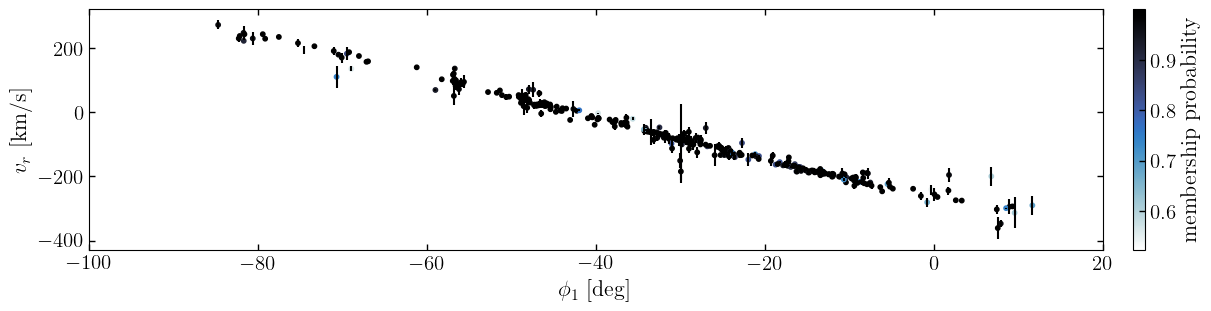

In [77]:
c_map='gray_r'

from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(12,3), layout="constrained")
gs = GridSpec(1, 1, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])

# im1 = ax1.scatter(all_data_[memb_sel1&~memb_sel2&cmd_sel&np.array(all_data_['rv']!=0)]['phi1'], all_data_[memb_sel1&~memb_sel2&cmd_sel&np.array(all_data_['rv']!=0)]['rv'], 
#                   c='r',
#                   s=10)

ax1.errorbar(all_data_[memb_sel1&(cmd_sel|bs_sel)&np.array(all_data_['rv']!=0)]['phi1'], all_data_[memb_sel1&(cmd_sel|bs_sel)&np.array(all_data_['rv']!=0)]['rv'], 
            yerr=all_data_[memb_sel1&(cmd_sel|bs_sel)&np.array(all_data_['rv']!=0)]['rv_err'],
            c='k', fmt='none')
im1 = ax1.scatter(all_data_[memb_sel1&(cmd_sel|bs_sel)&np.array(all_data_['rv']!=0)]['phi1'], all_data_[memb_sel1&(cmd_sel|bs_sel)&np.array(all_data_['rv']!=0)]['rv'], 
                  c=memb_prob[memb_sel1&(cmd_sel|bs_sel)&np.array(all_data_['rv']!=0)],
                  s=10, cmap=cmr.arctic_r, zorder=0)
ax1.set_xlabel(r"$\phi_1$ [deg]", fontsize=16)
ax1.set_ylabel(r"$v_r$ [km/s]", fontsize=16)
ax1.set_xlim(-100, 20)
# ax1.set_ylim(-500,500)
cbar = fig.colorbar(im1, ax=ax1, pad=0.02)
cbar.set_label('membership probability', fontsize=16)
plt.show()

In [78]:
import gala.dynamics as gd
import gala.potential as gp
from gala.units import galactic
gd1_coord_splines = gc.GD1Koposov10(phi1=phi1s*u.deg, phi2=phi2_track(phi1s)*u.deg, distance=10**((distmod_spl(phi1s)+5) / 5)*u.pc,
                pm_phi1_cosphi2=stream_pm1_track(phi1s)*u.mas/u.yr, pm_phi2=stream_pm2_track(phi1s)*u.mas/u.yr, 
                radial_velocity=stream_rv_track(phi1s)*u.km/u.s)
galcen_coord_splines = gd1_coord_splines.transform_to(coord.Galactocentric())
ws = gd.PhaseSpacePosition(pos=galcen_coord_splines, vel=galcen_coord_splines.velocity)
energy = ws.energy(gp.Hamiltonian(gp.MilkyWayPotential2022()))

membs = all_data_[memb_sel1 & (cmd_sel|bs_sel) &(all_data_['rv']!=0)]
membs_coord = coord.ICRS(ra=np.array(membs['ra'])*u.deg, dec=np.array(membs['dec'])*u.deg, distance=10**((distmod_spl(membs['phi1'].value)+5) / 5)*u.pc,
                              pm_ra_cosdec=np.array(membs['pmra'])*u.mas/u.yr, pm_dec=np.array(membs['pmdec'])*u.mas/u.yr,
                              radial_velocity=np.array(membs['rv'])*u.km/u.s)
galcen_membs = membs_coord.transform_to(coord.Galactocentric())
ws_membs = gd.PhaseSpacePosition(pos=galcen_membs, vel=galcen_membs.velocity)
energy_membs = ws_membs.energy(gp.Hamiltonian(gp.MilkyWayPotential2022()))

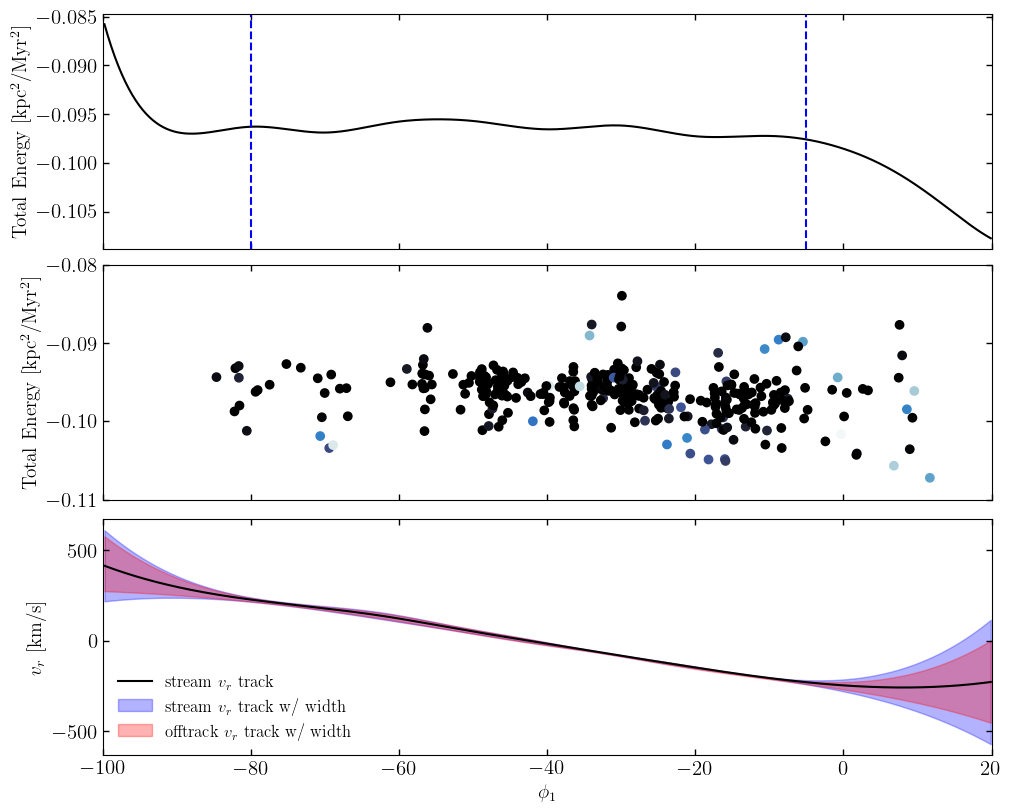

In [79]:
fig, [ax1, ax2, ax5] = plt.subplots(3,1, figsize=(10,8), sharex=True, constrained_layout=True)
ax1.plot(phi1s, energy)
ax1.axvline(-80, color='blue', ls='--');ax1.axvline(-5, color='blue', ls='--')
ax2.scatter(membs['phi1'], energy_membs, c=membs['memb_prob'], cmap=cmr.arctic_r)
ax2.set_ylim(-0.11, -0.08)
ax2.set_xlim(-100,20)

ax5.plot(phi1s, stream_rv_track(phi1s), c='k', label=r'stream $v_r$ track')
# ax4.errorbar(-2, -3.7, yerr=0.35, fmt='', capsize=5, color='black')
# ax4.text(1, -3.8, r'Median $\mu_{\phi_2}$ Error', fontsize=12)
ax5.fill_between(phi1s, stream_rv_track(phi1s) - stream_rv_width(phi1s), stream_rv_track(phi1s) + stream_rv_width(phi1s), 
                 color='b', alpha=0.3, label=r'stream $v_r$ track w/ width')
ax5.fill_between(phi1s, offtrack_rv_track(phi1s) - offtrack_rv_width(phi1s), offtrack_rv_track(phi1s) + offtrack_rv_width(phi1s), 
                 color='r', alpha=0.3, label=r'offtrack $v_r$ track w/ width')
ax5.set_ylabel(r'$v_r$ [km/s]', fontsize=14)
ax5.legend(fontsize=12, loc='lower left')
ax5.set_xlabel(r'$\phi_1$')
ax1.set_ylabel(r'Total Energy [kpc$^2$/Myr$^2$]')
ax2.set_ylabel(r'Total Energy [kpc$^2$/Myr$^2$]')

plt.show()

### Velocity Dispersion Along Stream

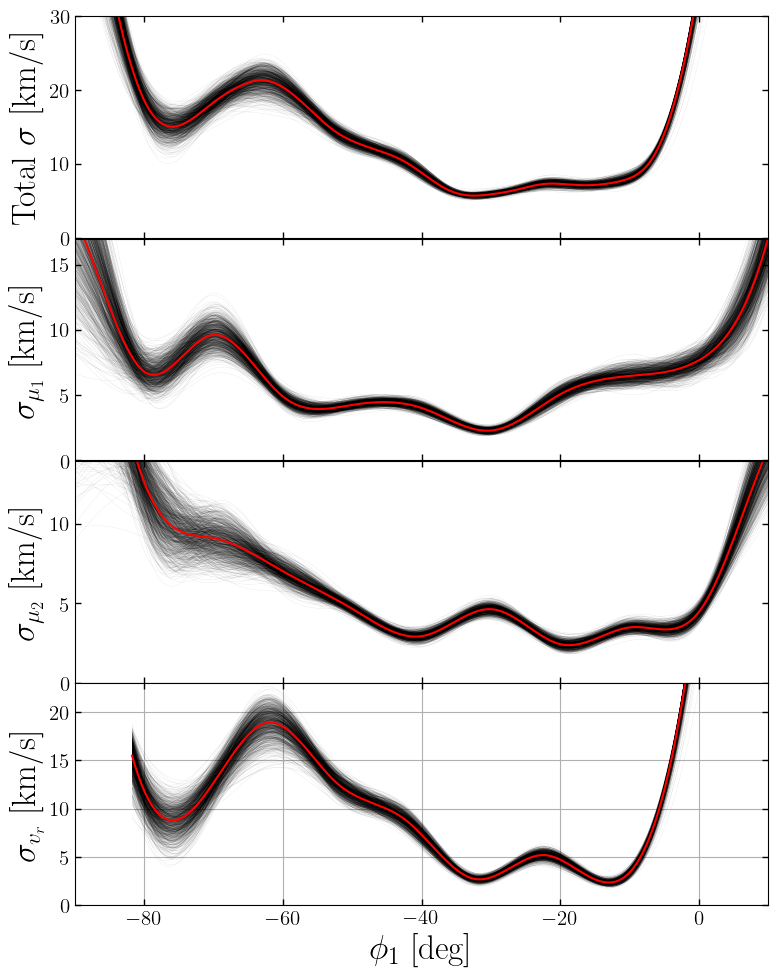

In [150]:
dist_pc = 10**((distmod_spl(phi1s)+5) / 5) * u.pc

spl_pm1_grid = np.zeros((pars_[f'stream:pm1:scale_vals'].shape[0], len(phi1s)))
spl_pm2_grid = np.zeros((pars_[f'stream:pm2:scale_vals'].shape[0], len(phi1s)))
spl_rv_grid = np.zeros((pars_[f'stream:rv:scale_vals'].shape[0], len(phi1s)))
spl_vel_disp_grid = np.zeros((pars_[f'stream:rv:scale_vals'].shape[0], len(phi1s)))

for i in range(pars_[f'stream:pm1:scale_vals'].shape[0]):
    spl_pm1 = IUS(mm['stream'].coord_parameters['pm1']['knots'], pars_['stream:pm1:scale_vals'][i], k=3)
    spl_pm2 = IUS(mm['stream'].coord_parameters['pm2']['knots'], pars_['stream:pm2:scale_vals'][i], k=3)
    spl_rv = IUS(mm['stream'].coord_parameters['rv']['knots'], pars_['stream:rv:scale_vals'][i], k=3)
    spl_pm1_grid[i] = (spl_pm1(phi1s) * u.mas/u.yr).to(u.rad/u.s) * dist_pc.to(u.km)
    spl_pm2_grid[i] = (spl_pm2(phi1s)  * u.mas/u.yr).to(u.rad/u.s) * dist_pc.to(u.km)
    spl_rv_grid[i] = spl_rv(phi1s)*u.km/u.s
    spl_vel_disp_grid[i] = np.linalg.norm(np.array([spl_pm1_grid[i], spl_pm2_grid[i], spl_rv_grid[i]]), axis=0)

    
fig, [ax1, ax2, ax3, ax4] = plt.subplots(4,1,figsize=(8,10), sharex=True)    
ax1.plot(phi1s, spl_vel_disp_grid.T, c='k', lw=0.1, alpha=0.25, rasterized=True)
ax1.plot(phi1s, np.linalg.norm(np.array([(stream_pm1_width(phi1s) * u.mas/u.yr).to(u.rad/u.s) * dist_pc.to(u.km),
                                         (stream_pm2_width(phi1s) * u.mas/u.yr).to(u.rad/u.s) * dist_pc.to(u.km), 
                                         stream_rv_width(phi1s)]), axis=0), c='r')
ax1.set_ylabel(r'Total $\sigma$ [km/s]', fontsize=24)
ax1.set_xlim(-90,10)
ax1.set_ylim(0,30)
# ax1.set_ylim(0,30)

ax2.plot(phi1s, spl_pm1_grid.T, c='k', lw=0.1, alpha=0.25, rasterized=True)
ax2.plot(phi1s, (stream_pm1_width(phi1s) * u.mas/u.yr).to(u.rad/u.s) * dist_pc.to(u.km), c='r')
ax2.set_ylabel(r' $\sigma_{\mu_1}$ [km/s]', fontsize=24)
ax2.set_ylim(0,17)

ax3.plot(phi1s, spl_pm2_grid.T, c='k', lw=0.1, alpha=0.25, rasterized=True)
ax3.set_ylabel(r'$\sigma_{\mu_2}$ [km/s]', fontsize=24)
ax3.plot(phi1s, (stream_pm2_width(phi1s) * u.mas/u.yr).to(u.rad/u.s) * dist_pc.to(u.km), c='r')
ax3.set_ylim(0,14)

ax4.plot(phi1s_rv, spl_rv_grid.T[(phi1s>-82)&(phi1s<3)], c='k', lw=0.1, alpha=0.25, rasterized=True)
ax4.plot(phi1s_rv, stream_rv_width(phi1s_rv), c='r')
ax4.set_ylim(0,23)
ax4.set_ylabel(r'$\sigma_{v_r}$ [km/s]', fontsize=24)
ax4.set_xlabel(r'$\phi_1$ [deg]', fontsize=24)
# fig.subplots_adjust(hspace=0)
ax4.grid()
plt.tight_layout(h_pad=-0.55)
plt.savefig('../../paper_figures/vel_dispersion.pdf')
plt.show()

In [81]:
stream_rv_width(phi1s_rv).min()

np.float64(2.328564486523115)

In [82]:
spl_vel_disp_grid[:,50:-50].min()

np.float64(5.116768087392031)

#### Nibauer+24 method (do same for pms?)

In [83]:
(memb_sel1 & (cmd_sel|bs_sel) & np.array(all_data_['rv'] != 0)).sum()

np.int64(353)

In [84]:
valluri_rv_phi1_knots = [-90, -70, -60,-46, -37.6, -29.2, -20.8, -15, -12.4, -4, 0, 20]
valluri_rvs = [79.79, 59.15, 27.61, -21.66, -46.38, -66.7, -93.19, -107.81, -113.29, -131.91, -144.31, -257.76]
valluri_rv_spl = IUS(valluri_rv_phi1_knots, valluri_rvs, k=3)

In [85]:
def rv_to_gsr(c, v_sun=None):
    """Transform a barycentric radial velocity to the Galactic Standard of Rest
    (GSR).

    The input radial velocity must be passed in as a

    Parameters
    ----------
    c : `~astropy.coordinates.BaseCoordinateFrame` subclass instance
        The radial velocity, associated with a sky coordinates, to be
        transformed.
    v_sun : `~astropy.units.Quantity`, optional
        The 3D velocity of the solar system barycenter in the GSR frame.
        Defaults to the same solar motion as in the
        `~astropy.coordinates.Galactocentric` frame.

    Returns
    -------
    v_gsr : `~astropy.units.Quantity`
        The input radial velocity transformed to a GSR frame.

    """
    if v_sun is None:
        v_sun = coord.Galactocentric().galcen_v_sun.to_cartesian()

    gal = c.transform_to(coord.Galactic())
    cart_data = gal.data.to_cartesian()
    unit_vector = cart_data / cart_data.norm()

    v_proj = v_sun.dot(unit_vector)

    return c.radial_velocity + v_proj

In [99]:
gd1_coord_splines = gc.GD1Koposov10(phi1=phi1s_rv*u.deg, phi2=phi2_track(phi1s_rv)*u.deg, distance=10**((distmod_spl(phi1s_rv)+5) / 5)*u.pc,
                pm_phi1_cosphi2=stream_pm1_track(phi1s_rv)*u.mas/u.yr, pm_phi2=stream_pm2_track(phi1s_rv)*u.mas/u.yr, 
                radial_velocity=stream_rv_track(phi1s_rv)*u.km/u.s)
low_gd1_coord_splines = gc.GD1Koposov10(phi1=phi1s_rv*u.deg, phi2=phi2_track(phi1s_rv)*u.deg, distance=10**((distmod_spl(phi1s_rv)+5) / 5)*u.pc,
                pm_phi1_cosphi2=stream_pm1_track(phi1s_rv)*u.mas/u.yr, pm_phi2=stream_pm2_track(phi1s_rv)*u.mas/u.yr, 
                radial_velocity=stream_rv_track_low(phi1s_rv)*u.km/u.s)
high_gd1_coord_splines = gc.GD1Koposov10(phi1=phi1s_rv*u.deg, phi2=phi2_track(phi1s_rv)*u.deg, distance=10**((distmod_spl(phi1s_rv)+5) / 5)*u.pc,
                pm_phi1_cosphi2=stream_pm1_track(phi1s_rv)*u.mas/u.yr, pm_phi2=stream_pm2_track(phi1s_rv)*u.mas/u.yr, 
                radial_velocity=stream_rv_track_high(phi1s_rv)*u.km/u.s)
galcen_coord_splines = gd1_coord_splines.transform_to(coord.ICRS())
low_galcen_coord_splines = low_gd1_coord_splines.transform_to(coord.ICRS())
high_galcen_coord_splines = high_gd1_coord_splines.transform_to(coord.ICRS())

In [100]:
# gd1_frame_track = gc.GD1Koposov10(phi1=phi1s*u.deg, phi2=phi2_track(phi1s)*u.deg, distance=10**((distmod_spl(phi1s)+5) / 5)*u.pc,
#                 pm_phi1_cosphi2=stream_pm1_track(phi1s)*u.mas/u.yr, pm_phi2=stream_pm2_track(phi1s)*u.mas/u.yr, 
#                 radial_velocity=stream_rv_track(phi1s)*u.km/u.s)
# icrs_track = gd1_frame_track.transform_to(coord.ICRS())
rv_track = rv_to_gsr(galcen_coord_splines)
low_rv_track = rv_to_gsr(low_galcen_coord_splines)
high_rv_track = rv_to_gsr(high_galcen_coord_splines)

In [151]:
very_high_prob = all_data_['memb_prob'] > 0.5
(very_high_prob & (cmd_sel|bs_sel) & np.array(all_data_['rv'] != 0)).sum()

np.int64(353)

Weighted standard deviation of residuals: 2.3519750388041745


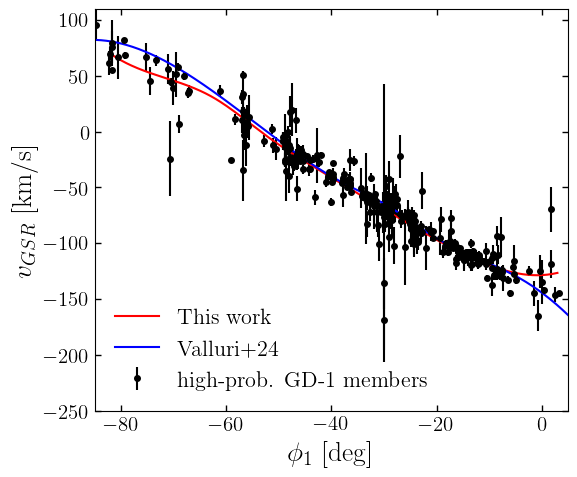

In [152]:
from scipy.optimize import curve_fit

# Define polynomial functions
def poly1(x, a, b):
    return a * x + b

def poly2(x, a, b, c):
    return a * x**2 + b * x + c

def poly3(x, a, b, c, d):
    return a * x**3 + b * x**2 + c * x + d

# Choose fitting function
fit_func = poly3  # Try higher-degree polynomials if necessary

# Sample dataset with errors
x_data = all_data_[very_high_prob & cmd_sel & np.array(all_data_['rv'] != 0)]['phi1']
y_data = all_data_[very_high_prob & cmd_sel & np.array(all_data_['rv'] != 0)]['rv']
icrs = coord.SkyCoord(ra=all_data_[very_high_prob & cmd_sel & np.array(all_data_['rv'] != 0)]['ra']*u.deg,
                      dec=all_data_[very_high_prob & cmd_sel & np.array(all_data_['rv'] != 0)]['dec']*u.deg,
                      radial_velocity=all_data_[very_high_prob & cmd_sel & np.array(all_data_['rv'] != 0)]['rv']*u.km/u.s,
                      frame='icrs')
rv_gsr = rv_to_gsr(icrs)
y_data = rv_gsr.value
y_errors = all_data_[very_high_prob & cmd_sel & np.array(all_data_['rv'] != 0)]['rv_err']

# Fit the chosen polynomial to the data
params, cov = curve_fit(fit_func, x_data, y_data, sigma=y_errors, absolute_sigma=True)

# Generate fitted values and residuals
y_fitted = fit_func(x_data, *params)
residuals = y_data - y_fitted

# Compute weights and weighted statistics
weights = 1 / y_errors**2
weighted_mean_residuals = np.sum(weights * residuals) / np.sum(weights)
weighted_std_dev = np.sqrt(np.sum(weights * (residuals - weighted_mean_residuals)**2) / np.sum(weights))

# Compute reduced chi-square
reduced_chi_square = np.sum(((y_data - y_fitted) / y_errors) ** 2) / (len(y_data) - len(params))

# print("Fitted coefficients:", params)
print("Weighted standard deviation of residuals:", weighted_std_dev)
# print("Reduced chi-square:", reduced_chi_square)

# Plot
fig, ax1 = plt.subplots(1, 1, figsize=(6, 5), sharex=True)

# Top plot: Data with error bars and fitted polynomial
phi1s = np.linspace(min(x_data), max(x_data), 500)  # Smooth curve
ax1.errorbar(x_data, y_data, yerr=y_errors, fmt='o', color='black', ms=4, alpha=1, label='high-prob. GD-1 members')
# ax1.plot(phi1s, fit_func(phi1s, *params), color='red', label=r'$v_r = -$'+f'{-params[0]:.3f}'+r'$\,\phi_1\:-\:$'+f'{-params[1]:.3f}')
ax1.plot(phi1s_rv, rv_track, color='red', label='This work')
# ax1.plot(phi1s_rv, rv_track.value+stream_rv_width(phi1s_rv), color='red', label='This work')
# ax1.plot(phi1s_rv, rv_track.value-stream_rv_width(phi1s_rv), color='red', label='This work')
plt.plot(phi1s, valluri_rv_spl(phi1s), color='blue', label='Valluri+24')
ax1.set_xlabel(r'$\phi_1$ [deg]', fontsize=20)
ax1.set_ylabel(r'$v_{GSR}$ [km/s]', fontsize=20)
ax1.legend(fontsize=16, loc='lower left')
# ax1.grid()
ax1.set_xlim(-85,5)
ax1.set_ylim(-250,110)

# # Bottom plot: Residuals with error bars
# ax2.errorbar(x_data, residuals, yerr=y_errors, fmt='o', color='green', label='Residuals with errors')
# ax2.axhline(0, color='black', linestyle='--', linewidth=1)
# ax2.set_xlabel('x')
# ax2.set_ylabel('Residuals')
# ax2.legend()
# ax2.grid()

plt.tight_layout()
# plt.savefig('../../paper_figures/high_prob_rv_members.pdf')
# plt.savefig('../../paper_figures/high_prob_rv_members.png')
plt.show()


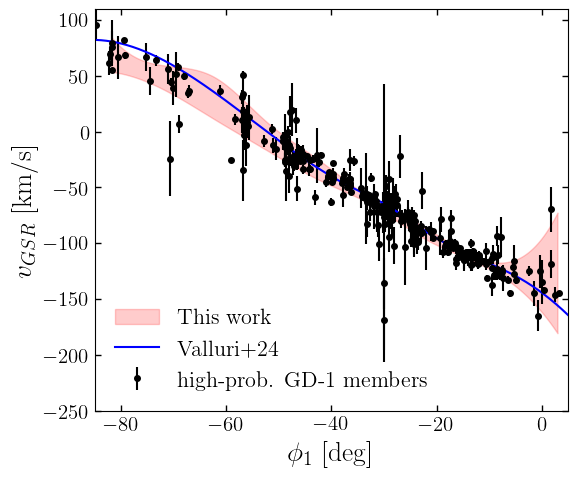

In [110]:
#### Plot
fig, ax1 = plt.subplots(1, 1, figsize=(6, 5), sharex=True)

# Top plot: Data with error bars and fitted polynomial
phi1s = np.linspace(min(x_data), max(x_data), 500)  # Smooth curve
ax1.errorbar(x_data, y_data, yerr=y_errors, fmt='o', color='black', ms=4, alpha=1, label='high-prob. GD-1 members')
# ax1.plot(phi1s, fit_func(phi1s, *params), color='red', label=r'$v_r = -$'+f'{-params[0]:.3f}'+r'$\,\phi_1\:-\:$'+f'{-params[1]:.3f}')
ax1.fill_between(phi1s_rv, rv_track.value-stream_rv_width(phi1s_rv), rv_track.value+stream_rv_width(phi1s_rv), 
                 color='red', label='This work', alpha=0.2)
# ax1.plot(phi1s_rv, rv_track.value+stream_rv_width(phi1s_rv), color='red', label='This work')
# ax1.plot(phi1s_rv, rv_track.value-stream_rv_width(phi1s_rv), color='red', label='This work')
plt.plot(phi1s, valluri_rv_spl(phi1s), color='blue', label='Valluri+24')
ax1.set_xlabel(r'$\phi_1$ [deg]', fontsize=20)
ax1.set_ylabel(r'$v_{GSR}$ [km/s]', fontsize=20)
ax1.legend(fontsize=16, loc='lower left')
# ax1.grid()
ax1.set_xlim(-85,5)
ax1.set_ylim(-250,110)

# # Bottom plot: Residuals with error bars
# ax2.errorbar(x_data, residuals, yerr=y_errors, fmt='o', color='green', label='Residuals with errors')
# ax2.axhline(0, color='black', linestyle='--', linewidth=1)
# ax2.set_xlabel('x')
# ax2.set_ylabel('Residuals')
# ax2.legend()
# ax2.grid()

plt.tight_layout()
plt.savefig('../../paper_figures/high_prob_rv_members.pdf')
plt.savefig('../../paper_figures/high_prob_rv_members.png')
plt.show()

In [111]:
params

array([ 1.61776967e-04,  1.75319616e-02, -2.04255972e+00, -1.40168849e+02])

In [112]:
reduced_chi_square

np.float64(14.096000882353175)

## Make Paper Plots

### Background Model

In [471]:
svi_results_dir = '/Users/Tavangar/Work/gd1-dr3/svi_results/'
bkg_filename = svi_results_dir + 'bkg_{}_{}_{}_{}_auto_normal.pkl'.format(*bkg_knot_spacings)

with open(bkg_filename, 'rb') as input_file_:
    bkg_dict = pickle.load(input_file_)
    
bkg_svi_results = bkg_dict['svi_results']
bkg_guide = bkg_dict['guide']

In [478]:
bkg_auto_loc_params_ = {}
for key, val in bkg_svi_results.params.items():
    if "auto_scale" in key:
        bkg_auto_loc_params_[key] = val/1e10
    else:
        bkg_auto_loc_params_[key] = val
        
bkg_pred_dist_auto_loc = Predictive(bkg_guide, params=bkg_auto_loc_params_, num_samples=1)
bkg_pars_auto_loc_ = bkg_pred_dist_auto_loc(jax.random.PRNGKey(12345), data=run_data)
bkg_pars_auto_loc = {k: jnp.median(v, axis=0) for k, v in bkg_pars_auto_loc_.items() if (k != '_auto_latent' and k != 'mixture:modeldata')}
bkg_best_params = mm['background'].expand_numpyro_params(bkg_pars_auto_loc)

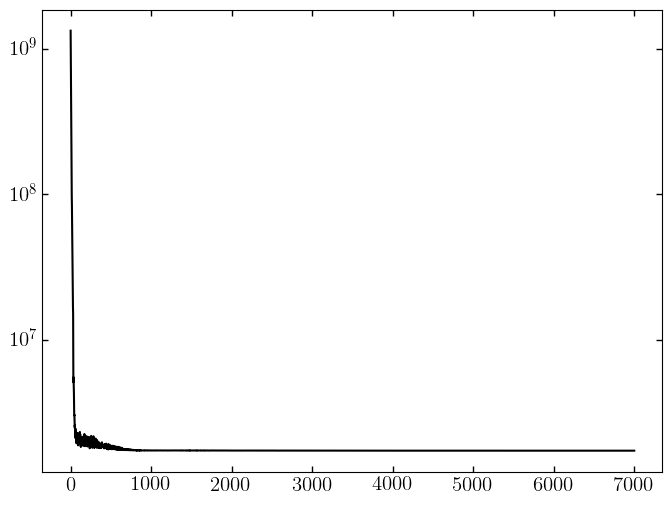

In [475]:
plt.plot(bkg_svi_results.losses)
# plt.ylim(1.4e6, 1.5e6)
plt.yscale('log')
plt.show()

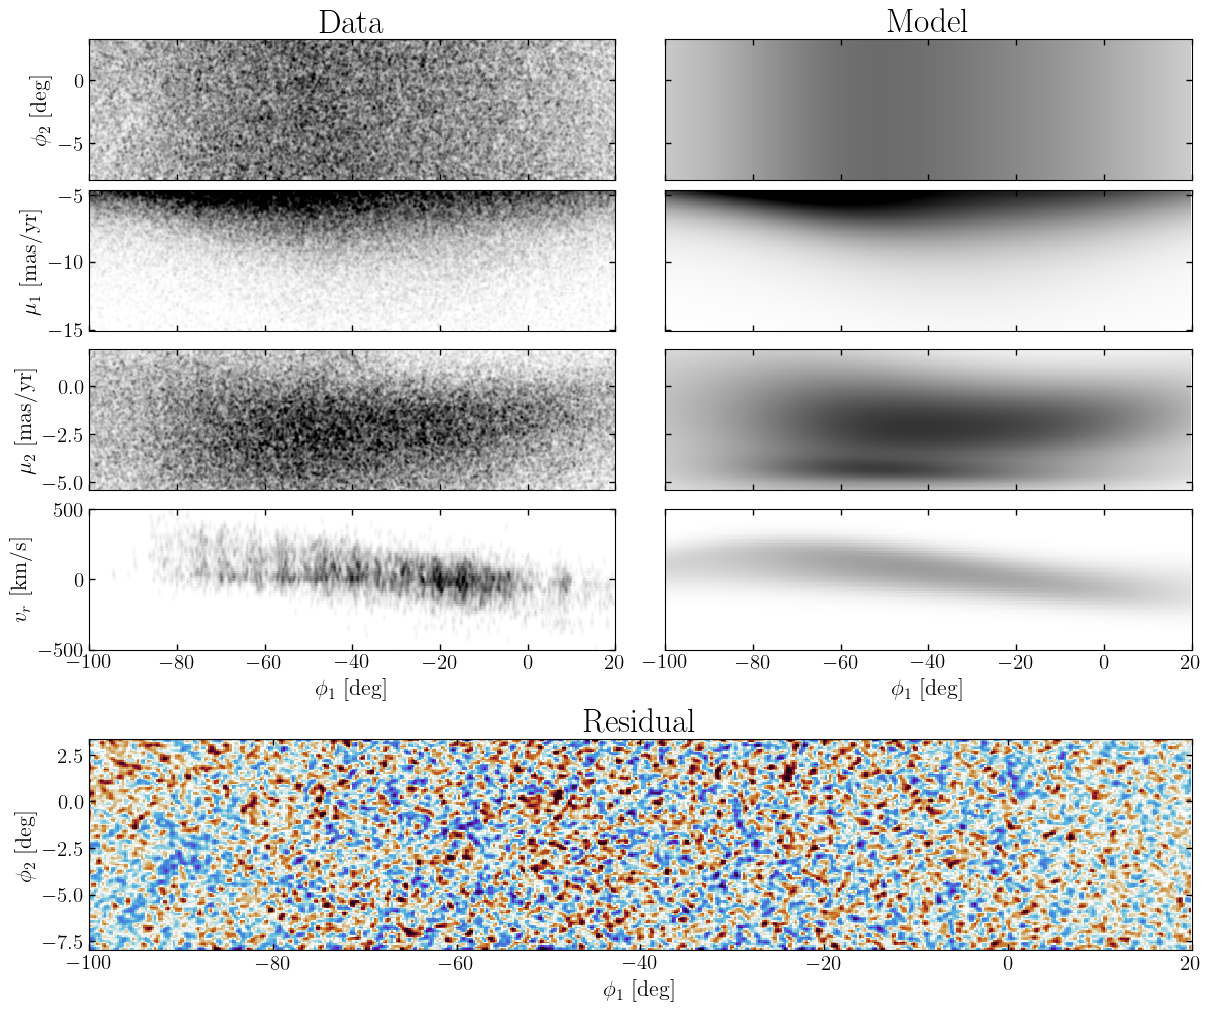

In [482]:
fig = plt.figure(figsize=(12, 10), constrained_layout=True)
gs = gridspec.GridSpec(5, 2, height_ratios=[1, 1, 1, 1, 1.5], figure=fig, hspace=0, wspace=0)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1], sharex=ax1, sharey=ax1)
ax3 = fig.add_subplot(gs[1, 0], sharex=ax1)
ax4 = fig.add_subplot(gs[1, 1], sharex=ax1, sharey=ax3)
ax5 = fig.add_subplot(gs[2, 0], sharex=ax1)
ax6 = fig.add_subplot(gs[2, 1], sharex=ax1, sharey=ax5)
ax7 = fig.add_subplot(gs[3, 0], sharex=ax1)
ax8 = fig.add_subplot(gs[3, 1], sharex=ax1, sharey=ax7)

ax9 = fig.add_subplot(gs[4, :], sharex=ax1)

plot_data_projections(
    data=bkg_data,
    grids=plot_grids,
    axes=ax3,
    coord_names=[('phi1', 'pm1')],
    pcolormesh_kwargs=dict(rasterized=True, vmax=5, vmin=0, cmap=cmap)
)
plot_data_projections(
    data=bkg_data,
    grids=plot_grids,
    axes=[ax1, ax5],
    pcolormesh_kwargs=dict(rasterized=True, vmax=3, vmin=0, cmap=cmap),
    coord_names=[('phi1', 'phi2'), ('phi1', 'pm2')]
)
plot_data_projections(
    data=only_rv_bkg_data,
    grids=plot_grids,
    axes=ax7,
    pcolormesh_kwargs=dict(rasterized=True, vmax=3, vmin=0, cmap=cmap),
    coord_names=[('phi1', 'rv')]
)

mm['background'].plot_model_projections(ndata=len(bkg_data_), grids=plot_grids, 
                          grid_coord_names=[('phi1', 'phi2'), ('phi1', 'pm1')],
                          pars=bkg_best_params, axes=[ax2,ax4], label=False,
                          pcolormesh_kwargs=dict(rasterized=True, vmax=5, vmin=0, cmap=cmap))
mm['background'].plot_model_projections(ndata=len(bkg_data_['rv'][bkg_data_['rv']!=0]), grids=plot_grids, grid_coord_names=[('phi1', 'phi2'), ('phi1', 'rv')],
                          pars=bkg_best_params, axes=[ax2,ax8], label=False,
                          pcolormesh_kwargs=dict(rasterized=True, vmax=3, vmin=0, cmap=cmap))
mm['background'].plot_model_projections(ndata=len(bkg_data_), grids=plot_grids, grid_coord_names=[('phi1', 'phi2'), ('phi1', 'pm2')],
                          pars=bkg_best_params, axes=[ax2,ax6], label=False,
                          pcolormesh_kwargs=dict(rasterized=True, vmax=3, vmin=0, cmap=cmap))

mm['background'].plot_residual_projections(
    grids=plot_grids, pars=bkg_best_params,
    data=bkg_data, axes=ax9, label=True, 
    pcolormesh_kwargs=dict(vmin=-1, vmax=1, rasterized=True, cmap=cmr.fusion),
    grid_coord_names=[('phi1', 'phi2')]
)

for ax in [ax1,ax2,ax3,ax4,ax5,ax6]:
    ax.label_outer()
ax8.yaxis.set_visible(False)
ax8.set_ylim(-500,500)
ax8.set_xlim(-100,20)

ax3.set_ylabel(r'$\mu_1$ [mas/yr]')
ax5.set_ylabel(r'$\mu_2$ [mas/yr]')

ax1.set_title('Data', fontsize=24)
ax2.set_title('Model', fontsize=24)
ax9.set_title('Residual', fontsize=24, pad=5)

plt.savefig('../../paper_figures/bkg_model.pdf')
plt.show()

### Stream Model

In [113]:
svi_results_dir = '/Users/Tavangar/Work/gd1-dr3/svi_results/'
stream_filename = svi_results_dir + 'stream_{}_{}_{}_{}_{}_auto_normal.pkl'.format(*stream_knot_spacings)

with open(stream_filename, 'rb') as input_file_:
    stream_dict = pickle.load(input_file_)
    
stream_svi_results = stream_dict['svi_results']
stream_guide = stream_dict['guide']

In [114]:
stream_auto_loc_params_ = {}
for key, val in stream_svi_results.params.items():
    if "auto_scale" in key:
        stream_auto_loc_params_[key] = val/1e10
    else:
        stream_auto_loc_params_[key] = val
        
stream_pred_dist_auto_loc = Predictive(stream_guide, params=stream_auto_loc_params_, num_samples=1)
stream_pars_auto_loc_ = stream_pred_dist_auto_loc(jax.random.PRNGKey(12345), data=stream_data)
stream_pars_auto_loc = {k: jnp.median(v, axis=0) for k, v in stream_pars_auto_loc_.items() if (k != '_auto_latent' and k != 'mixture:modeldata')}
stream_best_params = mm['stream'].expand_numpyro_params(stream_pars_auto_loc)

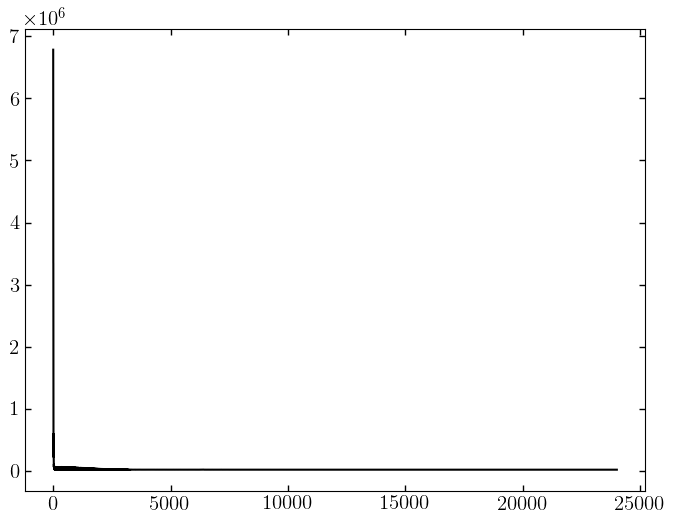

In [115]:
plt.plot(stream_svi_results.losses)
# plt.ylim(23000, 30000)
plt.show()

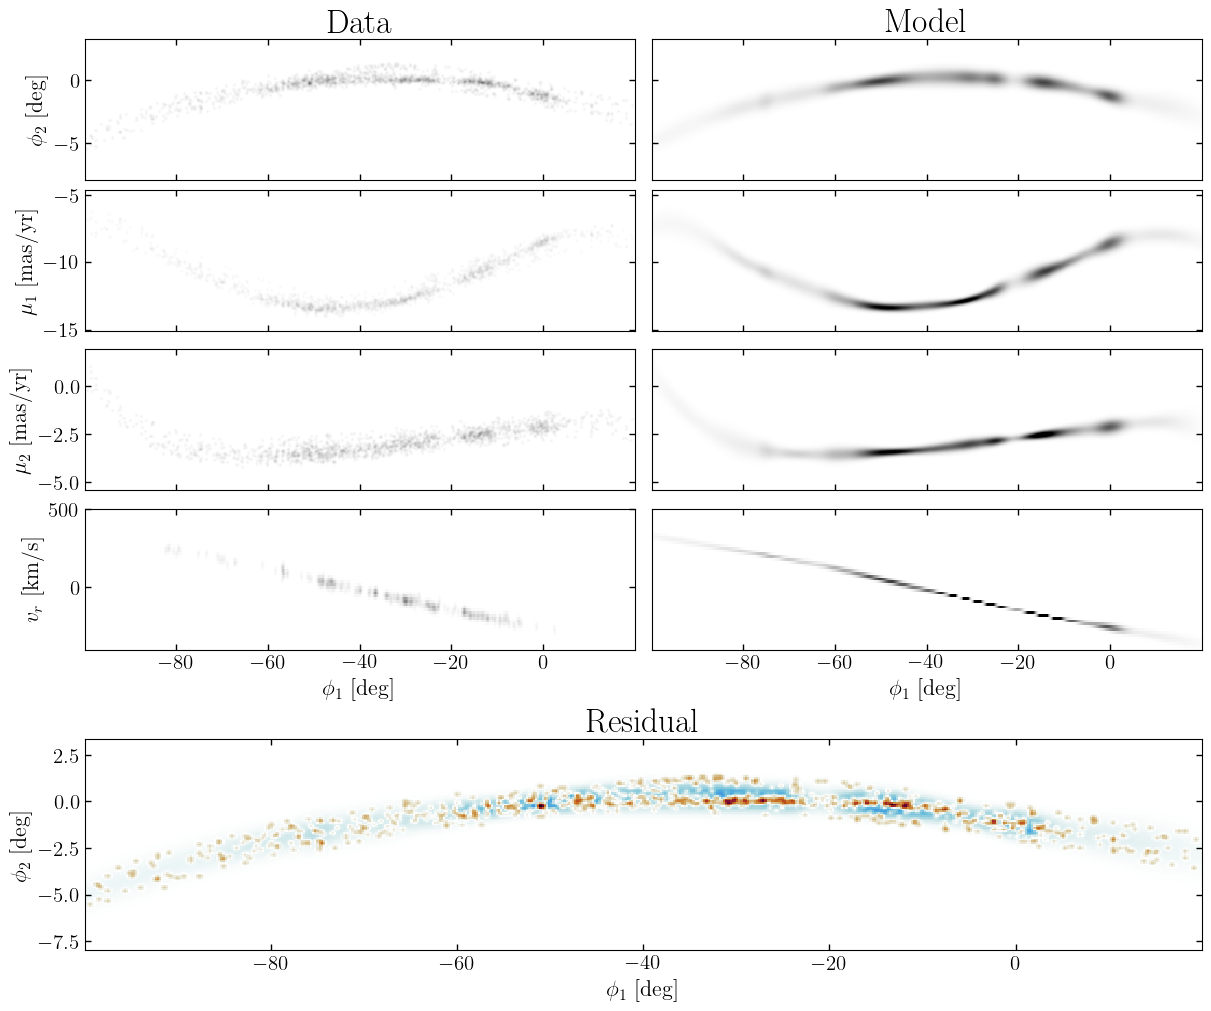

In [116]:
fig = plt.figure(figsize=(12, 10), constrained_layout=True)
gs = gridspec.GridSpec(5, 2, height_ratios=[1, 1, 1, 1, 1.5], figure=fig, hspace=0, wspace=0)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1], sharex=ax1, sharey=ax1)
ax3 = fig.add_subplot(gs[1, 0], sharex=ax1)
ax4 = fig.add_subplot(gs[1, 1], sharex=ax1, sharey=ax3)
ax5 = fig.add_subplot(gs[2, 0], sharex=ax1)
ax6 = fig.add_subplot(gs[2, 1], sharex=ax1, sharey=ax5)
ax7 = fig.add_subplot(gs[3, 0], sharex=ax1)
ax8 = fig.add_subplot(gs[3, 1], sharex=ax1, sharey=ax7)

ax9 = fig.add_subplot(gs[4, :], sharex=ax1)

plot_data_projections(
    data=stream_data,
    grids=plot_grids,
    axes=ax3,
    coord_names=[('phi1', 'pm1')],
    pcolormesh_kwargs=dict(rasterized=True, vmax=5, vmin=0, cmap=cmap)
)
plot_data_projections(
    data=stream_data,
    grids=plot_grids,
    axes=[ax1, ax5],
    pcolormesh_kwargs=dict(rasterized=True, vmax=3, vmin=0, cmap=cmap),
    coord_names=[('phi1', 'phi2'), ('phi1', 'pm2')]
)
plot_data_projections(
    data=only_rv_stream_data,
    grids=plot_grids,
    axes=ax7,
    pcolormesh_kwargs=dict(rasterized=True, vmax=3, vmin=0, cmap=cmap),
    coord_names=[('phi1', 'rv')]
)

mm['stream'].plot_model_projections(ndata=len(stream_data_), grids=plot_grids, 
                          grid_coord_names=[('phi1', 'phi2'), ('phi1', 'pm1')],
                          pars=stream_best_params, axes=[ax2,ax4], label=False,
                          pcolormesh_kwargs=dict(rasterized=True, vmax=1, vmin=0, cmap=cmap))
mm['stream'].plot_model_projections(ndata=len(stream_data_['rv'][stream_data_['rv']!=0]), grids=plot_grids, grid_coord_names=[('phi1', 'phi2'), ('phi1', 'rv')],
                          pars=stream_best_params, axes=[ax2,ax8], label=False,
                          pcolormesh_kwargs=dict(rasterized=True, vmax=1, vmin=0, cmap=cmap))
mm['stream'].plot_model_projections(ndata=len(stream_data_), grids=plot_grids, grid_coord_names=[('phi1', 'phi2'), ('phi1', 'pm2')],
                          pars=stream_best_params, axes=[ax2,ax6], label=False,
                          pcolormesh_kwargs=dict(rasterized=True, vmax=1, vmin=0, cmap=cmap))

mm['stream'].plot_residual_projections(
    grids=plot_grids, pars=stream_best_params,
    data=stream_data, axes=ax9, label=True, 
    pcolormesh_kwargs=dict(vmin=-1, vmax=1, rasterized=True, cmap=cmr.fusion),
    grid_coord_names=[('phi1', 'phi2')]
)


for ax in [ax1,ax2,ax3,ax4,ax5,ax6]:
    ax.label_outer()
ax8.yaxis.set_visible(False)
ax8.set_ylim(-400,500)

ax3.set_ylabel(r'$\mu_1$ [mas/yr]')
ax5.set_ylabel(r'$\mu_2$ [mas/yr]')

ax1.set_title('Data', fontsize=24)
ax2.set_title('Model', fontsize=24)
ax9.set_title('Residual', fontsize=24, pad=5)

plt.savefig('../../paper_figures/stream_model.pdf')
plt.show()

## Random check on the side

In [204]:
new_plot_grids = {}
for key, val in plot_grids.items():
    new_plot_grids[key] = val[::2]

In [249]:
pm1_poly = [[-74, -13.5], [-78, -15], [-92, -10], [-88, -9]]
pm1_patch = mpl.patches.Polygon(pm1_poly, edgecolor="k", facecolor="none")

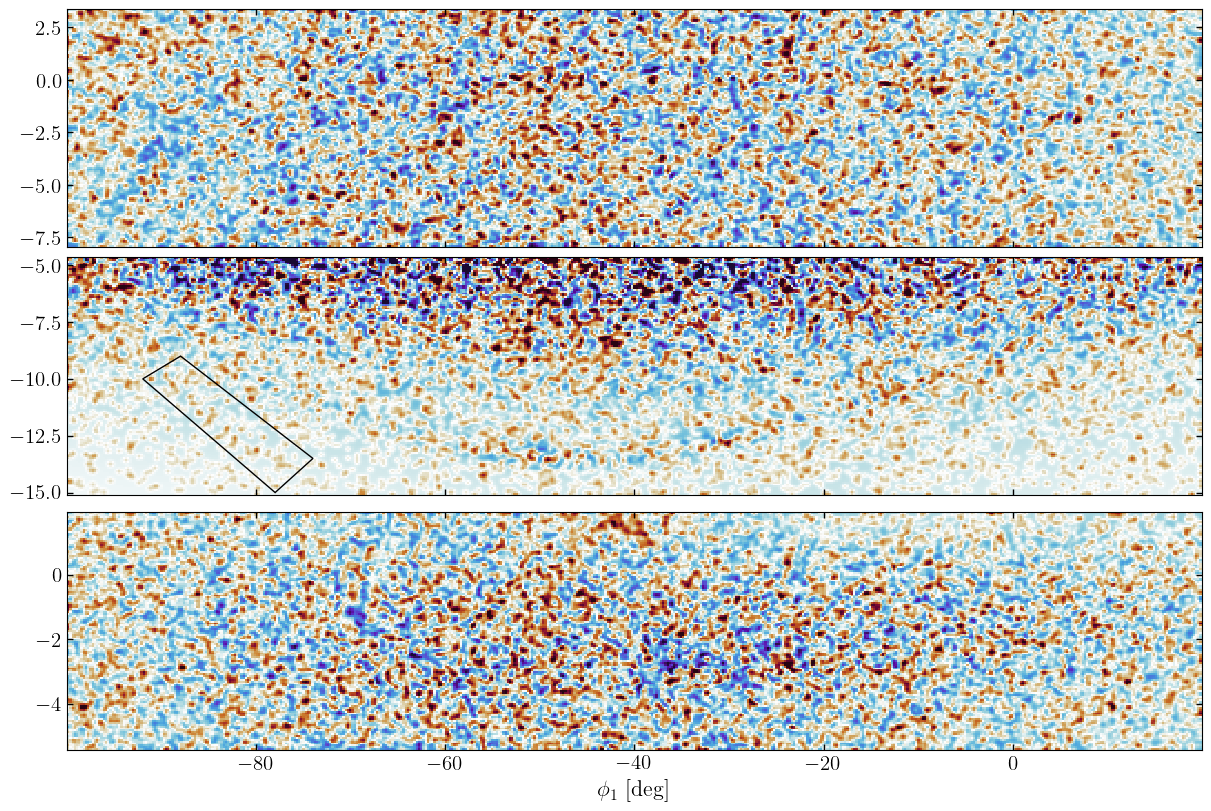

In [250]:
fig, axs = plt.subplots(3,1, figsize=(12,8), sharex=True, constrained_layout=True)
mm.plot_residual_projections(
    grids=plot_grids, pars=best_params,
    data=run_data, axes=axs, label=False, 
    pcolormesh_kwargs=dict(vmin=-1, vmax=1, rasterized=True, cmap=cmr.fusion)
)
axs[1].add_patch(pm1_patch)
plt.show()

In [251]:
pm1_poly = [[-74, -13.5], [-78, -15], [-92, -10], [-88, -9]]
pm1_patch = mpl.patches.Polygon(pm1_poly, edgecolor="k", facecolor="none")

In [252]:
sel = pm1_patch.contains_points(jnp.array([run_data_['phi1'], run_data_['pm1']]).T)

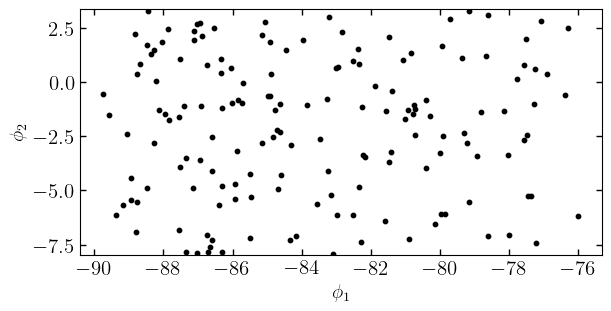

In [253]:
fig, ax1 = plt.subplots(1, 1, figsize=(6,3), sharex=True, sharey=True, constrained_layout=True)
im1 = ax1.scatter(run_data_[sel]['phi1'], run_data_[sel]['phi2'], s=10)
# ax1.scatter(all_data_[memb_sel1&bad_cmd_sel]['phi1'], all_data_[memb_sel1&bad_cmd_sel]['phi2'], s=1, c='r')
ax1.set_ylim(coord_bounds['phi2'])
ax1.set_xlabel(r'$\phi_1$')
ax1.set_ylabel(r'$\phi_2$')
plt.show()

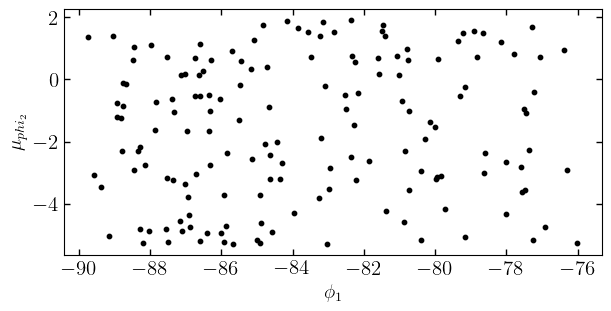

In [254]:
fig, ax1 = plt.subplots(1, 1, figsize=(6,3), sharex=True, sharey=True, constrained_layout=True)
im1 = ax1.scatter(run_data_[sel]['phi1'], run_data_[sel]['pm2'], s=10)
# ax1.scatter(all_data_[memb_sel1&bad_cmd_sel]['phi1'], all_data_[memb_sel1&bad_cmd_sel]['phi2'], s=1, c='r')
ax1.set_xlabel(r'$\phi_1$')
ax1.set_ylabel(r'$\mu_{phi_2}$')
plt.show()

### Visualizing different distance tracks

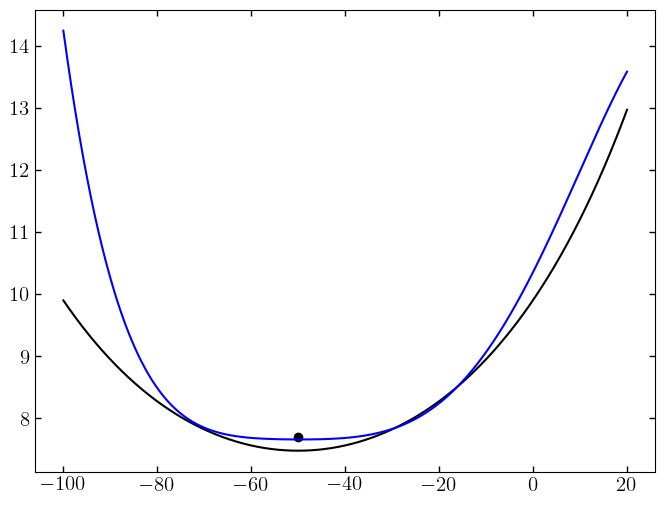

In [489]:
import numpy as np
import matplotlib.pyplot as plt
xs_deg = np.linspace(-100,20,1000)
xs_rad = np.deg2rad(xs_deg)

distmod_spl1 = np.poly1d([2.440e-4, 2.441e-2, 14.98]) #Valluri+24
distmod_spl2 = np.poly1d([-4.302, -11.54, -7.161, 5.985, 8.595, 10.36]) #Ibata+20 in radians

plt.plot(xs_deg, 0.001*10**((distmod_spl1(xs_deg)+5) / 5))
plt.plot(xs_deg, distmod_spl2(xs_rad))
plt.scatter(-50,7.7)
plt.show()

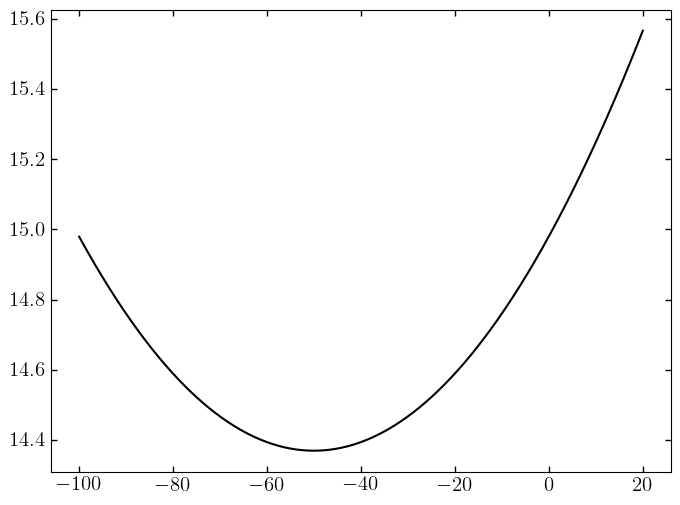

In [490]:
xs_deg = np.linspace(-100,20,1000)
plt.plot(xs_deg, distmod_spl(xs_deg))
plt.show()

## Stellar mass calculation

In [117]:
import imf
#cite https://github.com/keflavich/imf

Should we use an IMF if we no longer have any more high mass stars?

In [118]:
kroupa = imf.Kroupa()

cutoff1 = 1

over1fraction = (kroupa.m_integrate(cutoff1, kroupa.mmax)[0] /
                 kroupa.m_integrate(kroupa.mmin, kroupa.mmax)[0])

In [119]:
from isochrones.mist import MIST_Isochrone

mist = MIST_Isochrone()
iso = mist.isochrone(
    age=np.log10(1e9 * 12),  # has to be given in logAge
    feh=-2.5,
    eep_range=None,  # get the whole isochrone,
    distance=10,  # given in parsecs --> 10 ensures this is absolute magnitude which is a better tie to the way we cut our data
                  # could also just use the actual distance
)

initial_mass, actual_mass = iso.initial_mass.values, iso.mass.values
mag = iso.G_mag.values

Holoviews not imported. Some visualizations will not be available.
PyMultiNest not imported.  MultiNest fits will not work.


In [120]:
np.mean(actual_mass[np.where(mag<3.2)])

np.float64(0.8236390833551032)

In [121]:
np.where(mag<3.2)

(array([201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213,
        214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226,
        227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239,
        240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252,
        253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265,
        266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278,
        279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291,
        292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304,
        305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317,
        318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330,
        331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343,
        344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356,
        357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369,
        370, 371, 372, 373, 374, 375, 376, 377, 378

In [122]:
m_min = IUS(np.flip(mag[:201]), np.flip(actual_mass[:201]))(5.9)
m_turnoff = IUS(np.flip(mag[:201]), np.flip(actual_mass[:201]))(3.2)
print(m_min, m_turnoff)

0.6344641660573375 0.8265096083692022


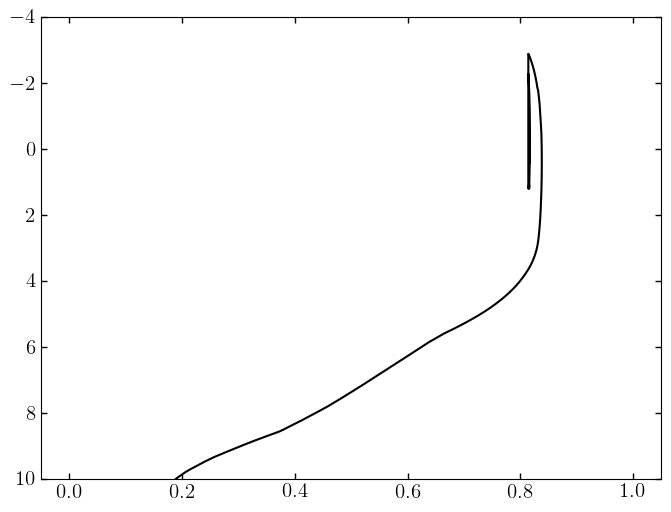

In [123]:
plt.plot(actual_mass, mag)
plt.hlines(20.5, 0,1, color='r', ls='--')
plt.vlines(0.61963443, 10,27, color='r', ls='--')
plt.ylim(10,-4)
plt.show()

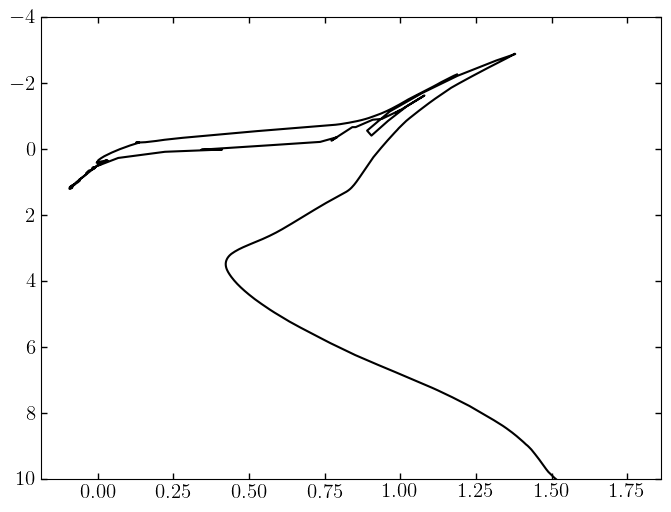

In [124]:
plt.plot(iso.BP_mag.values - iso.RP_mag.values, mag)
plt.ylim(10,-4)
plt.show()

In [125]:
kroupa = imf.Kroupa()

In [126]:
# calculate the fraction of mass that is below our detection limit relative to the total initial mass
undet2mtot = kroupa.m_integrate(kroupa.mmin, m_min)[0] / kroupa.m_integrate(kroupa.mmin, kroupa.mmax)[0]
print(undet2mtot)

0.3618518184670608


35.6\% of the initial mass of the cluster is below the detection threshold. I need to figure out how much mass has been lost via stellar evolution.

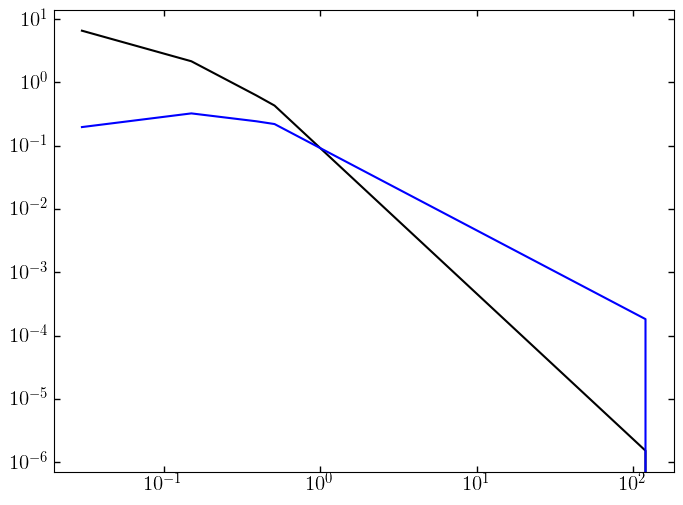

In [127]:
ms = np.linspace(kroupa.mmin, kroupa.mmax, 1000)

plt.loglog(ms, kroupa.dndm(ms))
plt.loglog(ms, kroupa.mass_weighted(ms))
plt.show()

In [131]:
distmod_spl = np.poly1d([2.440e-4, 2.441e-2, 14.98]) #Valluri+24
dist_mod_correct_cmd = distmod_spl(all_data_[memb_sel1&(cmd_sel|bs_sel)]["phi1"])

selection_Mg = (all_data_[memb_sel1&(cmd_sel|bs_sel)]['g0'] - dist_mod_correct_cmd)
mass_spline = IUS(np.flip(mag[:201]), np.flip(actual_mass[:201]))
total_mass_on_visible_complete_ms = mass_spline(selection_Mg[(selection_Mg < 5.9) & (selection_Mg>3.2)]).sum()
total_mass_on_visible_complete_ms

np.float64(940.769840175647)

In [132]:
n_ms_gd1 = len(selection_Mg[(selection_Mg < 5.9) & (selection_Mg>3.2)])
dn_ms = scipy.integrate.quad(kroupa.dndm, m_min, m_turnoff)[0]
norm_factor = n_ms_gd1/dn_ms
print(n_ms_gd1, norm_factor) #normalization factor is also equal to estimated number of stars in GD-1 at formation time

1278 34569.006725144674


In [133]:
n_undet = norm_factor * scipy.integrate.quad(kroupa.dndm, kroupa.mmin, m_min)[0]
print(n_undet)

30180.576894754257


In [134]:
detms2mtot = kroupa.m_integrate(m_min, m_turnoff)[0] / kroupa.m_integrate(kroupa.mmin, kroupa.mmax)[0]
print(detms2mtot)

0.06140871621325806


5.9\% of the mass is on the main sequence that we can see. There are 1403 detected stars in this area. Together, they have mass $\approx 1403\times0.7$. (feels like I'm going crazy not figuring out how to get that precisely

In [135]:
total_mass_on_visible_complete_ms / detms2mtot

np.float64(15319.809600131912)

So based on this I have $M_{ini} = 1.43\times10^4$ which is probably pretty accurate so maybe somehow this worked

In [136]:
undet2detms = kroupa.m_integrate(kroupa.mmin, m_min)[0] / kroupa.m_integrate(m_min, m_turnoff)[0]
print(undet2detms)

5.892515603329573


Also, there is 6.1 times as much mass in the undetected part as in the main sequence part so that is $\approx 1403*0.7*6.09 \approx 5976$ solar masses that are undetected

In [153]:
total_mass_on_visible_complete_ms*(undet2detms+1)

np.float64(6484.270802552516)

In [154]:
det_above_ms = len(all_data_[memb_sel1&(cmd_sel|bs_sel)&(all_data_['g0']<18)])
print(det_above_ms)

191


Above the region I have queried, there are only $\sim 209$ additional stars (added a handful of blue stragglers and according to the MIST Isochrone they basically al have mass 0.8 $M_\odot$ so the current mass is $\approx 5976 + 252\times0.8$

In [155]:
(undet2detms+1)*total_mass_on_visible_complete_ms + det_above_ms * np.mean(initial_mass[200:])

np.float64(6645.271747787895)

In [156]:
6645/15319

0.43377505059076965

### Total V-band magnitude

In [143]:
def get_total_M_V(G, BP, RP, distmod):
    G_m_V = -0.02704 + 0.01424*(BP-RP) - 0.2156*(BP-RP)**2 + 0.01426*(BP-RP)**3
    V = G - G_m_V
    M_V = V - distmod
    return -2.5*np.log10(np.sum(10**(-0.4*M_V)))

In [144]:
get_total_M_V(G=all_data_[memb_sel1&cmd_sel]['phot_g_mean_mag'],
              BP=all_data_[memb_sel1&cmd_sel]['phot_bp_mean_mag'],
              RP=all_data_[memb_sel1&cmd_sel]['phot_rp_mean_mag'],
              distmod=distmod_spl(all_data_[memb_sel1&cmd_sel]['phi1']))

np.float64(-4.732235734785636)